In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold

# DataBlock

In [348]:
home=os.getcwd()
home

'/users/qdb16186/CNN_stk'

In [3]:
#### MAC sklearn for CNN

###set global variables
# train test split
test_frac = 0.3
mc_cv=50
n_folds=5
n_jobs=1
epochs=200
grid_number=1
# Initialise train test split:
train_test_split = ShuffleSplit(mc_cv, test_size=test_frac, random_state=1)
train_test_split_hp = ShuffleSplit(1, test_size=test_frac, random_state=1)

In [498]:
prop='Granulated' 
GSHT='dH'
file=pd.read_csv("/users/qdb16186/CNN_stk/Lomzov_dataset_IY.csv")
# obtain y and x data
# y_1, y_2, y_3, y_4, x, X= load_data(file,prop)
desc_type = ['Granulated','OHEP','LP_dec2','DNA-Groups']
GSHT_list=['dH','dS','dG','Tm'] #get the order correct

# Data CV Block

to adjust CV and hyper parameter setup access:
cv_hp,
adjust test_size and shuffle split
<!--  -->


In [349]:
def path_fold(home,resample,i_fold):
    path="{}/CV/{}/fold_{}".format(os.getcwd(),resample,i_fold)
        
    # Define the directory path
    directory_path = Path(f"{home}/CV/{resample}/{i_fold}")
    
    # Ensure the directory exists, create it if necessary
    directory_path.mkdir(parents=True, exist_ok=True)

    return directory_path

def path_resample(home,resample):
    path="{}/CV/{}/".format(os.getcwd(),resample)
        
    # Define the directory path
    directory_path = Path(f"{home}/CV/{resample}")
    
    # Ensure the directory exists, create it if necessary
    directory_path.mkdir(parents=True, exist_ok=True)

    return directory_path

def cv_hp(df,home):
    resample_split  = ShuffleSplit(50, test_size=0.3, random_state=1)
    fold_split      = ShuffleSplit(5 , test_size=0.3, random_state=1)
    train_val_split = ShuffleSplit(1 , test_size=0.3, random_state=1)
    
    for resample, (train_val_index, test_index) in enumerate(resample_split.split(df)):
        train_val = pd.DataFrame(df['ID'].iloc[train_val_index])
        test = pd.DataFrame(df['ID'].iloc[test_index])
        for i, (train_index, val_index) in enumerate(train_val_split.split(train_val)):
            train = pd.DataFrame(df['ID'].iloc[train_index])
            val   = pd.DataFrame(df['ID'].iloc[val_index])
        resample_path = path_resample(home,resample)
        train.to_csv(f'{resample_path}/train.csv')
        val.to_csv(f'{resample_path}/val.csv')
        test.to_csv(f'{resample_path}/test.csv')
        # train,val,test to_csv
        for i_fold, (train_val_fold_index, test_fold_index) in enumerate(fold_split.split(train)):
            train_val_fold = pd.DataFrame(train['ID'].iloc[train_val_fold_index])
            test_fold = pd.DataFrame(train['ID'].iloc[test_fold_index])
            for i, (train_fold_index, val_fold_index) in enumerate(train_val_split.split(train_val_fold)):
                train_fold = pd.DataFrame(train_val_fold['ID'].iloc[train_fold_index])
                val_fold   = pd.DataFrame(train_val_fold['ID'].iloc[val_fold_index])
            i_fold_path = path_fold(home,resample,i_fold)
            train_fold.to_csv(f'{i_fold_path}/train.csv')
            val_fold.to_csv(f'{i_fold_path}/val.csv')
            test_fold.to_csv(f'{i_fold_path}/test.csv')
            

    return print("data organised into 50 CV with 5-fold inner CV")



In [350]:
df=pd.read_csv("Lomzov_dataset_IY.csv")
home=os.getcwd()
# pathlib.Path("Lomzov_dataset_IY.csv").parent.absolute()
cv_hp(df,home)

data organised into 50 CV with 5-fold inner CV


# Accessing Data Via ID CV and full table

In [8]:
def access_fold_csv(df,home,resample,fold):
    df_path = path_fold(home,resample,fold)
    train_df=pd.read_csv(f'{df_path}/train.csv')
    val_df=pd.read_csv(f'{df_path}/val.csv')
    test_df=pd.read_csv(f'{df_path}/test.csv')

    train_df=df[df["ID"].isin(train_df['ID'])]
    val_df=df[df["ID"].isin(val_df['ID'])]
    test_df=df[df["ID"].isin(test_df['ID'])]
    return train_df, val_df, test_df


def access_resample_csv(df,home,resample):
    df_path = path_resample(home,resample)
    train_df=pd.read_csv(f'{df_path}/train.csv')
    val_df=pd.read_csv(f'{df_path}/val.csv')
    test_df=pd.read_csv(f'{df_path}/test.csv')

    train_df=df[df["ID"].isin(train_df['ID'])]
    val_df=df[df["ID"].isin(val_df['ID'])]
    test_df=df[df["ID"].isin(test_df['ID'])]
    return train_df, val_df, test_df

In [9]:
resample=1
fold=1
train_fold, val_fold, test_fold = access_resample_csv(df,home,resample)

In [10]:
print(train_fold.shape, val_fold.shape, test_fold.shape)
# train_fold.shape
print(train_fold.shape[0] + val_fold.shape[0] + test_fold.shape[0])
# train_fold.shape

(149, 383) (64, 383) (92, 383)
305


# Load X, Y

In [11]:
def padding(X_descr_train_scaled):
#     Padding function so X data is always 250 dimensions
# Must be coupled with load_data. NB! double check if the scalling is not affected
# https://www.geeksforgeeks.org/python-call-function-from-another-function/
    a=X_descr_train_scaled.to_numpy()
    b=np.zeros((len(X_descr_train_scaled), 
                (250-int(X_descr_train_scaled.to_numpy().shape[1]))
               )
              )
    padded=np.concatenate((a,b),
                           axis=1, 
                          out=None, 
                          dtype=None
                         )
    return padded


def load_xy(file,desc):
    # Universal funciton for loading
# y_1, y_2, y_3, y_4 and x data from input csv (All, Train, Val or Train)
    y_1 = file[['dH']].copy()
    y_2 = file[['dS']].copy()
    y_3 = file[['dG']].copy()
    y_4 = file[['Tm']].copy()

    Y = file[['dH','dS','dG','Tm']].copy()
    # Convert y data into required input shape
    y_1 = y_1.to_numpy()
    y_1 = y_1.reshape(y_1.shape[0])
    y_2 = y_2.to_numpy()
    y_2 = y_2.reshape(y_2.shape[0])
    y_3 = y_3.to_numpy()
    y_3 = y_3.reshape(y_3.shape[0])
    y_4 = y_4.to_numpy()
    y_4 = y_4.reshape(y_4.shape[0])
    
    # Load features based on prop
    X = file[[col for col in file.columns if f'{desc}_'in col]]
    
    return y_1, y_2, y_3, y_4, Y, padding(X), X

    

    

In [12]:
df=pd.read_csv("Lomzov_dataset_IY.csv")
home=os.getcwd()
# pathlib.Path("Lomzov_dataset_IY.csv").parent.absolute()
cv_hp(df,home)

resample=1
fold=1
train, val, test = access_resample_csv(df,home,resample)
train_fold, val_fold, test_fold = access_fold_csv(df,home,resample,fold)

desc='RF-Score'
y_1_train, y_2_train, y_3_train, y_4_train, Y_train, X_padded_train, X_train = load_xy(train_fold,desc)
y_1_val,   y_2_val,   y_3_val,   y_4_val,   Y_val,   X_padded_val,   X_val   = load_xy(val_fold,desc)
y_1_test,  y_2_test,  y_3_test,  y_4_test,  Y_test,  X_padded_test,  X_test  = load_xy(test_fold,desc)


data organised into 50 CV with 5-fold inner CV


# Model

In [13]:
import tensorflow as tf
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras import layers, models, initializers, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

2024-01-26 17:02:47.949161: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-26 17:02:51.460543: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-26 17:02:51.461625: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-26 17:03:20.110481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
def r2_func(y_true, y_pred, **kwargs):
    return metrics.r2_score(y_true, y_pred)
def rmse_func(y_true, y_pred, **kwargs):
    return np.sqrt(metrics.mean_squared_error(y_true, y_pred))  
def bias_func(y_true, y_pred, **kwargs):
    return np.mean(y_true-y_pred)
def sdep_func(y_true, y_pred, **kwargs):
    return (np.mean((y_true-y_pred-(np.mean(y_true-y_pred)))**2))**0.5
#these 4 are for tensorflow formats
def r2_func_tf(y_true, y_pred, **kwargs):
    numerator = tf.reduce_sum(tf.square(y_true - y_pred))
    denominator = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1 - numerator / denominator
    return r2
def rmse_func_tf(y_true, y_pred, **kwargs):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    rmse = tf.sqrt(mse)
    return rmse
def bias_func_tf(y_true, y_pred, **kwargs):
    bias = tf.reduce_mean(y_true - y_pred)
    return bias
def sdep_func_tf(y_true, y_pred, **kwargs):
    diff = y_true - y_pred
    mean_diff = tf.reduce_mean(diff)
    sdep = tf.sqrt(tf.reduce_mean(tf.square(diff - mean_diff)))
    return sdep

In [15]:

def build_model(hp):
    
#     Hyper parameters         
    model_type1 = hp.Choice("model_type1", ["CNN3","CNN2","CNN1"])
    model_type = hp.Choice("model_type", ["Dense3"])
 
    
#     INPUT for NN
    
    inputs = keras.Input(shape=(250,1))
    x_layer=inputs
    
#     MANDATORY CNN (optional to move into first condition hp.cond_scope
    # with hp.conditional_scope("model_type1", ["CNN0"]):
    #         if model_type1 == "CNN0":
    #             pass
#     CONDITIONAL CONVOLUTION LAYERS (Consider moving the above into CNN1) test 0-3 CNN and 0-3 Dense
    with hp.conditional_scope("model_type1", ["CNN1","CNN2""CNN3"]):
            if model_type1 != "CNN0":
                x_layer = keras.layers.Conv1D(32, 
                        kernel_size=(3), 
                        strides=(2), 
                        padding='valid', 
                        activation='relu', 
                        input_shape=(250,1),
                        name = 'conv1d_1'
                        )(x_layer)
                x_layer = keras.layers.MaxPooling1D((2), name = 'maxpooling_1')(x_layer)
                x_layer = keras.layers.BatchNormalization(name = 'batchnorm_1')(x_layer)
                pass
                
            if model_type1 != "CNN1":
                x_layer = keras.layers.Conv1D(32, 
                                    kernel_size=(3), 
                                    strides=(2), 
                                    padding='valid', 
                                    activation='relu', 
                                    name = f'conv1d_2'
                                    )(x_layer)
                x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_2')(x_layer)
                x_layer = keras.layers.BatchNormalization(name = f'batchnorm_2')(x_layer)

            if model_type1 != "CNN1" or "CNN2":               
                x_layer = keras.layers.Conv1D(32, 
                                    kernel_size=(3), 
                                    strides=(2), 
                                    padding='valid', 
                                    activation='relu', 
                                    name = f'conv1d_3'
                                    )(x_layer)
                x_layer = keras.layers.MaxPooling1D((2), name = f'maxpooling_3')(x_layer)
                x_layer = keras.layers.BatchNormalization(name = f'batchnorm_3')(x_layer)
                
#     FLATTEN AFTER CONVOLUTIONS
    x_layer = keras.layers.Flatten(name = 'flatten')(x_layer)
    
#     CONDITIONAL DENSE LAYERS
    # with hp.conditional_scope("model_type", ["Dense0"]):
    #     if model_type == "Dense0":
    #         pass
            
    with hp.conditional_scope("model_type", ["Dense3"]): #["Dense1","Dense2","Dense3"]
        if model_type != "Dense0":
            hp_layer_1= hp.Choice(f'layer_1', values=[16,32,64,128])

            x_layer = keras.layers.Dense(
                        hp_layer_1,
                        activation='relu',
                        use_bias=True,
                        # name='layer_1',
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x_layer)
        if model_type != "Dense1":
            hp_layer_2_2= hp.Choice(f'layer_2_2', values=[16,32,64,128])

            x_layer = keras.layers.Dense(
                        hp_layer_2_2,
                        activation='relu',
                        use_bias=True,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x_layer)

        if model_type != "Dense1" or "Dense2":
            hp_layer_3_3= hp.Choice(f'layer_3_3',  values=[16,32,64])
            
            x_layer = keras.layers.Dense(
                        hp_layer_3_3,
                        activation='relu',
                        use_bias=True,
                        kernel_initializer='glorot_uniform',
                        bias_initializer='zeros',
                        kernel_regularizer=None,
                        bias_regularizer=None,
                        activity_regularizer=None,
                        kernel_constraint=None,
                        bias_constraint=None
                    )(x_layer)
#     OUTPUT LAYERS

    # output_1 = keras.layers.Dense(1, name='enthalpy_pred')(x_layer)
    # output_2 = keras.layers.Dense(1, name='entropy_pred')(x_layer)
    # output_3 = keras.layers.Dense(1, name='free_energy_pred')(x_layer)
    # output_4 = keras.layers.Dense(1, name='melting_temperature')(x_layer)

    # output_1 = keras.layers.Dense(1, name='dH')(x_layer)
    # output_2 = keras.layers.Dense(1, name='dS')(x_layer)
    # output_3 = keras.layers.Dense(1, name='dG')(x_layer)
    # output_4 = keras.layers.Dense(1, name='Tm')(x_layer)
    

    # model = Model(inputs=inputs, outputs=[output_1, output_2, output_3, output_4])
    output_1 = keras.layers.Dense(1, name='output')(x_layer)
    model = Model(inputs=inputs, outputs=output_1)
    
#     SETTINGS
#     SETTINGS

#     ADAPTIVE LEARNING RATE   
    
    initial_learning_rate = 0.01
    decay_steps = 10.0
    decay_rate = 0.5
    learning_rate_fn = keras.optimizers.schedules.InverseTimeDecay(
                                    initial_learning_rate, decay_steps, decay_rate)
    
#     SETTING ADAM OPTIMISER
    optimiser = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)
    
#     COMPILE MODEl
    model.compile(loss = "mse" , 
                  optimizer = optimiser, 
                  metrics = ["mse",'mean_absolute_error',r2_func_tf, rmse_func_tf, bias_func_tf, sdep_func_tf])   
    
    return model

# Model Evaluation

In [16]:
epochs = 2
batch  = 16
# TODO: Use path lib to create path
fold_path = path_fold(home,resample,fold)
resample_path = path_resample(home,resample)

# model_name = architecture of - Single task/RF/KNN + dH/dG/dS/Tm or - Multitask  
prop = 'dH' 
model_name = f"1DConv_st_{prop}" 


# Define the directory path
directory_path = Path(f"{fold_path}/{desc}/{model_name}/")

tunner_path      = Path(f'{directory_path}/tunner')
csv_logger_path  = Path(f'{directory_path}/csv_logger/')
cp_callback_path = Path(f'{directory_path}/model_checkpoint/')
tensorboard_path = Path(f'{directory_path}/tensorboard_logs/')

# Ensure the directory exists, create it if necessary
tunner_path.mkdir(parents=True, exist_ok=True)
csv_logger_path.mkdir(parents=True, exist_ok=True)
cp_callback_path.mkdir(parents=True, exist_ok=True)
tensorboard_path.mkdir(parents=True, exist_ok=True)


tuner = kt.GridSearch(build_model,
                   objective=kt.Objective('val_loss', 'min'),
                    # loss = 'val_loss',
                   # objective = ['val_mse','val_free_energy_pred_mse'],
                  directory=tunner_path,
                  overwrite=False,
                  project_name=f'{batch}')

with open(f'{tunner_path}/tuner_path.txt', 'w') as f:
    f.write(tuner.project_dir)
f.close

#### CALL BACKS!
es = EarlyStopping(monitor      = 'val_loss', 
                        mode     = 'min', 
                        verbose  = 1, 
                        patience = 2000, 
                    restore_best_weights = True)
# CSV Logger
csv_logger = CSVLogger(f'{csv_logger_path}/model_history.csv' , append=True)

# CP_callbacks      not required when using a tunner       
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{cp_callback_path}/cp.ckpt',
#                                                  save_weights_only=True,
#                                                  verbose=1)

# TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path, 
                                                       #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                      update_freq = 1,
                                                      # histogram_freq=1, 
                                                      write_graph=False, 
                                                      write_images=False)
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

# Covert to list and provide to Keras Regressor
keras_callbacks = [es, csv_logger, tensorboard_callback]


# history=tuner.search(x_hp_train, y_hp_train[:],
#             epochs = epochs,
#             batch_size=batch,
#             verbose = 2,
#             validation_data =(x_hp_val, y_hp_val[:]),
#              # validation_split = 0.2,
#             callbacks=keras_callbacks)

Reloading Tuner from /users/qdb16186/CNN_stk/CV/1/1/RF-Score/1DConv_st_dH/tunner/16/tuner0.json


In [17]:
y_1_train, y_2_train, y_3_train, y_4_train, Y_train, X_padded_train, X_train = load_xy(train_fold,desc)
y_1_val,   y_2_val,   y_3_val,   y_4_val,   Y_val,   X_padded_val,   X_val   = load_xy(val_fold,desc)
y_1_test,  y_2_test,  y_3_test,  y_4_test,  Y_test,  X_padded_test,  X_test  = load_xy(test_fold,desc)

In [18]:
tunner_path

PosixPath('/users/qdb16186/CNN_stk/CV/1/1/RF-Score/1DConv_st_dH/tunner')

In [ ]:

history=tuner.search(X_padded_train, y_1_train,
            epochs = epochs,
            batch_size=batch,
            verbose = 3,
            validation_data =(X_padded_val, y_1_val),
             # validation_split = 0.2,
            callbacks=keras_callbacks)

# Submit Job

In [19]:
desc_type = ['Granulated','OHEP','LP_dec2']
GSHT_list=['dH','dS','dG','Tm']

# Code for Grid Search Analysis

In [20]:
# from sklearn import metrics
# from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.metrics import mean_absolute_error
import sys

In [303]:
def stats_hp(y_test_pred, Y_test, prop):
    y_test_np = Y_test[f'{prop}'].to_numpy()
    y_pred_test_np = y_test_pred

    r2_test = r2_score(y_test_np, y_pred_test_np)
    rmsd_test = (mean_squared_error(y_test_np, y_pred_test_np))**0.5
    bias_test = np.mean(y_pred_test_np - y_test_np)
    sdep_test = (np.mean((y_pred_test_np - y_test_np - bias_test)**2))**0.5
    r2 = '{:.3f}'.format(r2_test)
    rmsd = '{:.3f}'.format(rmsd_test)
    bias = '{:.3f}'.format(bias_test)
    sdep = '{:.3f}'.format(sdep_test)
    
    
    mse=mean_squared_error(y_test_np, y_pred_test_np)
    mse='{:.3f}'.format(mse)
    mae=mean_absolute_error(y_test_np, y_pred_test_np)
    mae='{:.3f}'.format(mae)
    try:
        a, b = np.polyfit(y_test_np, y_pred_test_np, 1)
        plot_a = '{:.3f}'.format(a[0])
        plot_b = '{:.3f}'.format(b[0])
    except np.linalg.LinAlgError:
        pass
    
    return r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae

In [22]:
def grid_analysis(df,home,resample,fold,prop,desc,model_name):
    df2=pd.DataFrame()
    keyList = ['trial',
               'model_type1', 'model_type',
               'layer_3_3', 'layer_2_2', 'layer_1',
               f'r2_{prop}_{fold}',
               f'rmsd_{prop}_{fold}',
               f'bias_{prop}_{fold}',
               f'SDEP_{prop}_{fold}',
               f'gradient_{prop}_{fold}',
               f'b_{prop}_{fold}',
               f'mse_{prop}_{fold}',
               f'mae_{prop}_{fold}']
    n = dict(zip(keyList, [None]*len(keyList)))
    
    df_grid=pd.DataFrame(n,index=['a'])
   
    dir=path_fold(home, resample, fold)
    # model_name = f"1DConv_st_{prop}" 
    tunner_path =f"{dir}/{desc}/{model_name}/tunner"
    tuner = kt.GridSearch(build_model,
                           objective=kt.Objective('val_loss', 'min'),
                            # loss = 'val_loss',
                           # objective = ['val_mse','epoch_entropy_pred_mse','val_free_energy_pred_mse'],
                          directory=tunner_path,
                          overwrite=False,
                          project_name=f'{batch}')

    # Find all trial number and cycle through them
    selection=os.listdir(tuner.project_dir)
    for dir_ in selection:
        if "trial_" not in dir_:
            continue
        trial_number=str(dir_.replace("trial_",""))
        trial=tuner.oracle.get_trial(trial_number)
        model=tuner.load_model(trial)

        # train, val, test = access_resample_csv(df,home,resample)
        train_fold, val_fold, test_fold = access_fold_csv(df,home,resample,fold)
        
        y_1_train, y_2_train, y_3_train, y_4_train, Y_train, X_padded_train, X_train = load_xy(train_fold,desc)
        y_1_val,   y_2_val,   y_3_val,   y_4_val,   Y_val,   X_padded_val,   X_val   = load_xy(val_fold,desc)
        y_1_test,  y_2_test,  y_3_test,  y_4_test,  Y_test,  X_padded_test,  X_test  = load_xy(test_fold,desc)

        y_test_pred = model.predict(X_padded_test)
        
        r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred, Y_test, prop)
        if trial_number in df_grid.index:
            n = df_grid.loc[trial_number].to_dict()
        n.update({"trial":trial_number,})
        n.update({f'r2_{prop}_{fold}':r2,f'rmsd_{prop}_{fold}': rmsd, 
                  f'bias_{prop}_{fold}': bias, f'SDEP_{prop}_{fold}': sdep,
                  f'gradient_{prop}_{fold}': plot_a, f'b_{prop}_{fold}': plot_b, 
                  f'mse_{prop}_{fold}':mse, f'mae_{prop}_{fold}':mae,})

        original_stdout = sys.stdout 	
        with open(f'{prop}_{fold}_{resample}.txt', 'w') as f:
            sys.stdout = f
            trial.display_hyperparameters()
            # Reset the standard output
            sys.stdout = original_stdout 
        f.close
        data = open(f'{prop}_{fold}_{resample}.txt', 'r').read()
        data_hyp_param=data.replace(': ','\n').split('\n')
        i_index=0
        while i_index+1 < len(data_hyp_param):
            n.update({data_hyp_param[i_index]:data_hyp_param[i_index+1]})
            i_index+=2
        os.system(f'rm {prop}_{fold}_{resample}.txt')

        df_grid.loc[f'{trial_number}']=n
    df_grid.to_csv(f'{dir}/{desc}/{model_name}/{prop}_{fold}.csv')
    # df_grid.to_csv(f'{prop}_{fold}.csv')
    return

In [ ]:
desc='Granulated'
df=pd.read_csv("Lomzov_dataset_IY.csv")
batch=16
os.chdir('/users/qdb16186/CNN_stk')
for resample in range(0,1):
    for prop in GSHT_list:
        for fold in range(5):
            grid_analysis(df,home,resample,fold,prop,desc,model_name)





    




# print(dir/"Granulated"/model_name)

## Add an archiving function after the Prop_fold.csv file is generated
it will free 1400-3000 files and will allow for the workflow to continue sequentially 

In [231]:
import tarfile
import os

In [258]:
def create_tar_archive(work_dir,files):
    # Create a tar.gz archive
    with tarfile.open(f"{work_dir}tuner_results.tar.gz", "w:gz") as archive:
        for file in files:
            archive.add(f"{work_dir}{file}", arcname=os.path.basename(f"{file}"))
        archive.close()
        
def archive_hyper_params(home,resample,fold,prop,desc,model_name):
    # prop not required
    dir=path_fold(home, resample, fold)
    folder_dir=f'{dir}/{desc}/{model_name}/'
    folders_to_archive=os.listdir(folder_dir)
    create_tar_archive(folder_dir, folders_to_archive)

def delete_folders_after_archive(home,resample,fold,prop,desc,model_name):
    # prop not required
    dir=path_fold(home, resample, fold)
    folder_dir=f'{dir}/{desc}/{model_name}/'
    folders_to_archive=os.listdir(folder_dir)
    folders_to_archive = list(filter(lambda i:'.' not in i, folders_to_archive))
    for folder in folders_to_archive:
        os.system(f'rm -r {folder_dir}{folder}')

# def untargz(home,resample,fold,prop,model_name):
#     dir=path_fold(home, resample, fold)
#     folder_dir=f'{dir}/{desc}/{model_name}/'
#     archive_name=f'{folder_dir}tuner_results.tar.gz"
def display_tar_contents(file_path):
    with tarfile.open(file_path, "r:gz") as archive:
        print("Contents of the tar file:")
        archive.list() 

In [246]:
archive_hyper_params(home,resample,fold,prop,desc,model_name)
delete_folders_after_archive(home,resample,fold,prop,desc,model_name)

In [347]:
display_tar_contents(f'/users/qdb16186/CNN_stk/CV/0/0/DNA-Groups/1DConv_st_Tm/tuner_results.tar.gz')

Contents of the tar file:
?rwxr-xr-x qdb16186/users          0 2024-01-28 14:25:22 csv_logger/ 
?rw-r--r-- qdb16186/users    1071714 2024-01-28 14:34:07 csv_logger/model_history.csv 
?rwxr-xr-x qdb16186/users          0 2024-01-28 14:25:19 tunner/ 
?rwxr-xr-x qdb16186/users          0 2024-01-28 14:33:49 tunner/16/ 
?rw-r--r-- qdb16186/users       3515 2024-01-28 14:34:07 tunner/16/oracle.json 
?rwxr-xr-x qdb16186/users          0 2024-01-28 14:25:45 tunner/16/trial_0000/ 
?rw-r--r-- qdb16186/users         77 2024-01-28 14:25:45 tunner/16/trial_0000/checkpoint 
?rw-r--r-- qdb16186/users     112979 2024-01-28 14:25:45 tunner/16/trial_0000/checkpoint.data-00000-of-00001 
?rw-r--r-- qdb16186/users       4015 2024-01-28 14:25:45 tunner/16/trial_0000/checkpoint.index 
?rw-r--r-- qdb16186/users       2636 2024-01-28 14:26:02 tunner/16/trial_0000/trial.json 
?rwxr-xr-x qdb16186/users          0 2024-01-28 14:26:24 tunner/16/trial_0001/ 
?rw-r--r-- qdb16186/users         77 2024-01-28 14:26:24

## Combine all grids and Evaluate

In [49]:
test_df1=pd.read_csv('Tm_4.csv')
test_df2=pd.read_csv('Tm_3.csv')
test_df3=pd.read_csv('Tm_2.csv')
test_df=pd.concat([test_df1,test_df2,test_df3],
                 axis=1)
print(len(test_df.columns))
df_cleaned = test_df.T.drop_duplicates().T
print(len(df_cleaned.columns))
df_cleaned.columns
stats_list=['r2','rmsd','bias','SDEP','gradient','b','mse','mae']
GSHT_list=['dH','dS','dG','Tm']

# for prop in GSHT_List:
#     for stats in stats_list:
#         temp_list=[]
#         for fold in range(5):
#             temp_list.append(
# df_cleaned



45
31


## Single Task access grid search results  from each fold and select best paramters for Train val Test evaluation of Model. 

In [261]:
df_combine = pd.DataFrame()
df_summary = pd.DataFrame()
df_combine_all = pd.DataFrame()

# for resample in range(1):
df_combine_all = pd.DataFrame()
df_summary = pd.DataFrame()
for prop in GSHT_list[0:1]:
    print(prop)
for fold in range(5):
    dir = path_fold(home, resample, fold)
    model_name = f"1DConv_st_{prop}"
    try:
        df_read=pd.read_csv(f'{dir}/{desc}/{model_name}/{prop}_{fold}.csv')
        # Combine
        df_combine=pd.concat([df_combine,df_read],
                            axis=1)
    except:
        pass
        
    # count=0
df_combine = df_combine.T.drop_duplicates().T
for stat in stats_list:
    columns_to_compute = df_combine.filter(regex=f'^{stat}_{prop}')
    # print(columns_to_compute)
    # Compute mean and std for the specified columns
    mean_values = df_combine.filter(regex=f'^{stat}_{prop}').mean(axis=1)
    std_values = df_combine.filter(regex=f'^{stat}_{prop}').std(axis=1)
    df_combine_all[f'{stat}_{prop}_mean'] = mean_values
    df_combine_all[f'{stat}_{prop}_std']  = std_values
    if stat == 'r2' or stat =='rmsd':
        df_summary[f'{stat}_{prop}_mean'] = mean_values
        df_summary[f'{stat}_{prop}_std']  = std_values

df_summary['trial_id']=df_combine['Unnamed: 0']
#  Find the trial number with the best hyper paramteres
trial_number_fin_model = df_summary.loc[df_summary[f'r2_{prop}_mean'].idxmax()]['trial_id']

# Load best hyper parameters into a dataframe
best_hps=df_combine.loc[df_combine['Unnamed: 0']==trial_number_fin_model][df_combine.columns[2:7]]

# Load Hyper parameters for final model
hp = kt.HyperParameters()

model_type1 = hp.Choice("model_type1", [best_hps.values[0, 0]])
model_type = hp.Choice("model_type", [best_hps.values[0, 1]])
hp_layer_1= hp.Choice(f'layer_1', values=[best_hps.values[0, 4]])
hp_layer_2_2= hp.Choice(f'layer_2_2', values=[best_hps.values[0, 3]])
hp_layer_3_3= hp.Choice(f'layer_3_3',  values=[best_hps.values[0, 2]])

# Build final model
test_model=build_model(hp)

# Inputs for training final Model
epochs = 300
batch  = 16
# TODO: Use path lib to create path
resample_path = path_resample(home,resample)

# model_name = architecture of - Single task/RF/KNN + dH/dG/dS/Tm or - Multitask  
prop = 'dH' 
model_name = f"1DConv_st_{prop}" 


# Define the directory path
directory_path = Path(f"{os.getcwd()}/CV/{resample}/{desc}/{model_name}/")

# Define Paths for call backs
csv_logger_path  = Path(f'{directory_path}/csv_logger/')
cp_callback_path = Path(f'{directory_path}/model_checkpoint/')
tensorboard_path = Path(f'{directory_path}/tensorboard_logs/')

# Ensure the directory exists, create it if necessary
csv_logger_path.mkdir(parents=True, exist_ok=True)
cp_callback_path.mkdir(parents=True, exist_ok=True)
tensorboard_path.mkdir(parents=True, exist_ok=True)


#### CALL BACKS!
es = EarlyStopping(monitor      = 'val_loss', 
                        mode     = 'min', 
                        verbose  = 1, 
                        patience = 2000, 
                    restore_best_weights = True)
# CSV Logger
csv_logger = CSVLogger(f'{csv_logger_path}/model_history.csv' , append=True)

# CP_callbacks      not required when using a tunner       
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{cp_callback_path}/cp.ckpt',
#                                                  save_weights_only=True,
#                                                  verbose=1)

# TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path, 
                                                       #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                      update_freq = 1,
                                                      # histogram_freq=1, 
                                                      write_graph=False, 
                                                      write_images=False)
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

# Covert to list and provide to Keras Regressor
keras_callbacks = [es, csv_logger, tensorboard_callback]

# Load resample data
y_1_train, y_2_train, y_3_train, y_4_train, Y_train, X_padded_train, X_train = load_xy(train,desc)
y_1_val,   y_2_val,   y_3_val,   y_4_val,   Y_val,   X_padded_val,   X_val   = load_xy(val,desc)
y_1_test,  y_2_test,  y_3_test,  y_4_test,  Y_test,  X_padded_test,  X_test  = load_xy(test,desc)

# Train model on resample data
history=test_model.fit(X_padded_train, y_1_train,
            epochs = epochs,
            batch_size=batch,
            verbose = 2,
            validation_data =(X_padded_val, y_1_val),
             # validation_split = 0.2,
            callbacks=keras_callbacks)
# Make predictions


# Store stats


# Store csv files (predictions vs true)


def stats_csv(y_test_pred, Y_test, prop, csv_name, set_type,resample):
    y_test_np = Y_test[f'{prop}'].to_numpy()
    y_pred_test_np = y_test_pred

    r2_test = r2_score(y_test_np, y_pred_test_np)
    rmsd_test = (mean_squared_error(y_test_np, y_pred_test_np))**0.5
    bias_test = np.mean(y_pred_test_np - y_test_np)
    sdep_test = (np.mean((y_pred_test_np - y_test_np - bias_test)**2))**0.5
    r2 = '{:.3f}'.format(r2_test)
    rmsd = '{:.3f}'.format(rmsd_test)
    bias = '{:.3f}'.format(bias_test)
    sdep = '{:.3f}'.format(sdep_test)
    
    
    mse=mean_squared_error(y_test_np, y_pred_test_np)
    mse='{:.3f}'.format(mse)
    mae=mean_absolute_error(y_test_np, y_pred_test_np)
    mae='{:.3f}'.format(mae)
    try:
        a, b = np.polyfit(y_test_np, y_pred_test_np, 1)
        plot_a = '{:.3f}'.format(a[0])
        plot_b = '{:.3f}'.format(b[0])
    except np.linalg.LinAlgError:
        pass
        # 'index':np.array(Y_test.index),'ID':np.array(Y_test.index +1),
    y_pred_test_np = y_test_pred.squeeze()
    csv_df=pd.DataFrame({'index':np.array(Y_test.index),'ID':np.array(Y_test.index +1),'y_true': y_test_np, 'y_pred': y_pred_test_np})
    csv_df.to_csv(csv_name,index=None)

    csv_df_stats=pd.DataFrame(data=np.array([[resample, r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae]]),
                              # index=None, 
                              columns=['resample','r2','rmsd', 'bias', 'sdep', 'plot_a', 'plot_b', 'mse', 'mae'])
    csv_df_stats.to_csv(f'{csv_name[:-4]}_stats.csv',mode='a',index='resample')
    
    return csv_df



set_types = ['train','val','test']
# set_type = 'test'
# csv_name=f'{directory_path}/{set_type}.csv'
# csv_name=f'{set_type}.csv'

list_indexes = [train, val, test]
index_counter=-1
for indexes in list_indexes:
    index_counter+=1
    csv_name=f'{directory_path}/{set_types[index_counter]}.csv'
    y_1,  y_2,  y_3,  y_4,  Y,  X_padded,  X  = load_xy(indexes,desc)
    predictions = test_model.predict(X_padded)
    csv_df = stats_csv(predictions, Y, prop, csv_name, set_types[index_counter],resample)


dH


# Dev

In [262]:
df_combine = pd.DataFrame()
df_summary = pd.DataFrame()
df_combine_all = pd.DataFrame()

for resample in range(1):
    for prop in GSHT_list[0:1]:
        print(prop)
        for fold in range(5):
            dir = path_fold(home, resample, fold)
            model_name = f"1DConv_st_{prop}"
            try:
                df_read=pd.read_csv(f'{dir}/{desc}/{model_name}/{prop}_{fold}.csv')
                # Combine
                df_combine=pd.concat([df_combine,df_read],
                                    axis=1)
            except:
                pass
                
            count=0
    df_combine = df_combine.T.drop_duplicates().T
        # Append to summary
             
        # append Combine all_all
# df_read=pd.read_csv(f'{dir}/{desc}/{model_name}/{prop}_{fold}.csv')
# df_combine.to_csv('test.csv')
df_combine.filter(regex=f'^r2_').max()


r2_dH_0    0.949
r2_dH_1    0.941
r2_dH_2    0.941
r2_dH_3    0.925
r2_dH_4    0.932
dtype: object

## Quality check r2 is near 1 for Tm, dS, dG,

In [303]:
# trial_number=str(dir_.replace("trial_",""))

keyList = ['trial',
               'model_type1', 'model_type',
               'layer_3_3', 'layer_2_2', 'layer_1',
               f'r2_{prop}_{fold}',
               f'rmsd_{prop}_{fold}',
               f'bias_{prop}_{fold}',
               f'SDEP_{prop}_{fold}',
               f'gradient_{prop}_{fold}',
               f'b_{prop}_{fold}',
               f'mse_{prop}_{fold}',
               f'mae_{prop}_{fold}']
n = dict(zip(keyList, [None]*len(keyList)))
    
df_grid=pd.DataFrame(n,index=['a'])
tunner_path =f"{dir}/{desc}/{model_name}/tunner"
tuner = kt.GridSearch(build_model,
                       objective=kt.Objective('val_loss', 'min'),
                        # loss = 'val_loss',
                       # objective = ['val_mse','epoch_entropy_pred_mse','val_free_energy_pred_mse'],
                      directory=tunner_path,
                      overwrite=False,
                      project_name=f'{batch}')
trial_number= "0000"
trial=tuner.oracle.get_trial(trial_number)
model=tuner.load_model(trial)

# train, val, test = access_resample_csv(df,home,resample)
train_fold, val_fold, test_fold = access_fold_csv(df,home,resample,fold)

y_1_train, y_2_train, y_3_train, y_4_train, Y_train, X_padded_train, X_train = load_xy(train_fold,desc)
y_1_val,   y_2_val,   y_3_val,   y_4_val,   Y_val,   X_padded_val,   X_val   = load_xy(val_fold,desc)
y_1_test,  y_2_test,  y_3_test,  y_4_test,  Y_test,  X_padded_test,  X_test  = load_xy(test_fold,desc)

y_test_pred = model.predict(X_padded_test)

r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred, Y_test, prop)
if trial_number in df_grid.index:
    n = df_grid.loc[trial_number].to_dict()
n.update({"trial":trial_number,})
n.update({f'r2_{prop}_{fold}':r2,f'rmsd_{prop}_{fold}': rmsd, 
          f'bias_{prop}_{fold}': bias, f'SDEP_{prop}_{fold}': sdep,
          f'gradient_{prop}_{fold}': plot_a, f'b_{prop}_{fold}': plot_b, 
          f'mse_{prop}_{fold}':mse, f'mae_{prop}_{fold}':mae,})

df_grid.loc[f'{trial_number}']=n
df_grid
# df_grid.to_csv(f'{dir}/{desc}/{model_name}/{prop}_{fold}.csv')

Reloading Tuner from /users/qdb16186/CNN_stk/CV/0/4/Granulated/1DConv_st_Tm/tunner/16/tuner0.json
2/2 [==============================] - 0s 4ms/step


,trial,model_type1,model_type,layer_3_3,layer_2_2,layer_1,r2_Tm_4,rmsd_Tm_4,bias_Tm_4,SDEP_Tm_4,gradient_Tm_4,b_Tm_4,mse_Tm_4,mae_Tm_4
a,None,None,None,None,None,None,None,None,None,None,None,None,None,None
0000,0000,None,None,None,None,None,-77.216,119.505,-114.436,25.577,-1.456,-9.267,14281.389,114.436


In [304]:
y_test_pred

array([[ -70.89455 ],
       [ -61.303577],
       [ -48.985935],
       [ -58.889317],
       [ -60.54698 ],
       [ -64.19579 ],
       [ -62.51336 ],
       [ -60.31459 ],
       [ -62.39605 ],
       [ -88.56169 ],
       [ -70.2349  ],
       [ -54.926983],
       [ -69.96466 ],
       [ -71.48666 ],
       [ -67.105774],
       [ -93.73913 ],
       [ -74.96023 ],
       [-114.72769 ],
       [ -82.142876],
       [ -28.205814],
       [ -57.142204],
       [ -60.29847 ],
       [-113.06404 ],
       [ -50.81727 ],
       [ -63.179466],
       [ -46.530346],
       [-115.39568 ],
       [-115.31091 ],
       [ -60.80287 ],
       [ -63.58795 ],
       [ -88.15382 ],
       [ -59.3305  ],
       [-117.883316],
       [-118.450226],
       [-111.86006 ],
       [ -60.717278],
       [ -62.408756],
       [ -59.25267 ],
       [ -63.498764],
       [ -61.32525 ],
       [ -57.973038],
       [ -61.160408],
       [ -48.69654 ],
       [ -76.624626],
       [ -63.049324]], dtype=flo

In [305]:
Y_test

,dH,dS,dG,Tm
2,-78.3,-231.0,-6.7,32.0
5,-54.6,-151.0,-7.9,36.0
6,-45.4,-128.0,-5.7,22.4
13,-65.6,-191.0,-6.4,29.7
23,-58.6,-164.0,-7.6,35.9
32,-60.0,-166.0,-8.4,40.0
42,-62.0,-170.0,-9.4,46.0
43,-47.9,-129.0,-7.8,36.6
45,-57.9,-162.0,-7.8,35.4
46,-76.2,-213.0,-10.1,46.2


## Analysis to extract, select based on Test set

In [263]:
# df_combine=df_combine.dropna()
# df_combine.loc[df_combine['r2_dH_mean'].idxmax()]
df_combine.columns
df_combine

,Unnamed: 0,trial,model_type1,model_type,layer_3_3,layer_2_2,layer_1,r2_dH_0,rmsd_dH_0,bias_dH_0,...,mse_dH_3,mae_dH_3,r2_dH_4,rmsd_dH_4,bias_dH_4,SDEP_dH_4,gradient_dH_4,b_dH_4,mse_dH_4,mae_dH_4
0,a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0049,49.0,CNN2,Dense3,32.0,16.0,16.0,0.928,5.906,-2.318,...,26.489,4.033,0.912,6.993,0.393,31.911,0.873,-8.621,48.906,5.393
2,0041,41.0,CNN3,Dense3,64.0,32.0,128.0,0.926,6.004,-1.363,...,26.305,4.023,0.913,6.953,1.605,33.192,0.951,-1.89,48.348,5.406
3,0092,92.0,CNN2,Dense3,64.0,64.0,128.0,0.926,5.992,-0.463,...,64.941,5.324,0.904,7.298,1.723,32.734,0.919,-3.99,53.266,5.74
4,0000,0.0,CNN3,Dense3,16.0,16.0,16.0,0.94,5.421,-0.981,...,23.64,3.64,0.907,7.19,2.528,32.216,0.894,-5.017,51.699,5.955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,0134,134.0,CNN1,Dense3,64.0,16.0,128.0,0.929,5.896,-0.705,...,23.955,3.979,0.917,6.786,1.333,33.167,0.951,-2.173,46.054,5.248
141,0096,96.0,CNN1,Dense3,16.0,16.0,16.0,0.925,6.025,-0.463,...,22.892,3.748,0.929,6.284,1.086,32.755,0.931,-3.774,39.495,4.824
142,0129,129.0,CNN1,Dense3,16.0,128.0,64.0,0.932,5.743,-0.642,...,22.894,3.778,0.912,6.974,1.2,33.339,0.958,-1.764,48.64,5.222
143,0139,139.0,CNN1,Dense3,32.0,64.0,128.0,0.932,5.774,-0.016,...,29.685,4.112,0.918,6.742,1.448,33.453,0.969,-0.783,45.451,5.245


In [44]:
df_combine_all = pd.DataFrame()
df_summary = pd.DataFrame()
for prop in GSHT_list:
    try:
        for stat in stats_list:
            columns_to_compute = df_combine.filter(regex=f'^{stat}_{prop}')
            # print(columns_to_compute)
            # Compute mean and std for the specified columns
            mean_values = df_combine.filter(regex=f'^{stat}_{prop}').mean(axis=1)
            std_values = df_combine.filter(regex=f'^{stat}_{prop}').std(axis=1)
            df_combine_all[f'{stat}_{prop}_mean'] = mean_values
            df_combine_all[f'{stat}_{prop}_std']  = std_values
            if stat == 'r2' or stat =='rmsd':
                df_summary[f'{stat}_{prop}_mean'] = mean_values
                df_summary[f'{stat}_{prop}_std']  = std_values
    except:
        pass



In [82]:
prop='dH'
for stat in stats_list:
    columns_to_compute = df_combine.filter(regex=f'^{stat}_{prop}')
    # print(columns_to_compute)
    # Compute mean and std for the specified columns
    mean_values = df_combine.filter(regex=f'^{stat}_{prop}').mean(axis=1)
    std_values = df_combine.filter(regex=f'^{stat}_{prop}').std(axis=1)
    df_combine_all[f'{stat}_{prop}_mean'] = mean_values
    df_combine_all[f'{stat}_{prop}_std']  = std_values
    if stat == 'r2' or stat =='rmsd':
        df_summary[f'{stat}_{prop}_mean'] = mean_values
        df_summary[f'{stat}_{prop}_std']  = std_values
df_summary['trial_id']=df_combine['Unnamed: 0']

In [83]:
df_combine

,Unnamed: 0,trial,model_type1,model_type,layer_3_3,layer_2_2,layer_1,r2_dH_0,rmsd_dH_0,bias_dH_0,...,mse_dH_3,mae_dH_3,r2_dH_4,rmsd_dH_4,bias_dH_4,SDEP_dH_4,gradient_dH_4,b_dH_4,mse_dH_4,mae_dH_4
0,a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0049,49.0,CNN2,Dense3,32.0,16.0,16.0,0.928,5.906,-2.318,...,26.489,4.033,0.912,6.993,0.393,31.911,0.873,-8.621,48.906,5.393
2,0041,41.0,CNN3,Dense3,64.0,32.0,128.0,0.926,6.004,-1.363,...,26.305,4.023,0.913,6.953,1.605,33.192,0.951,-1.89,48.348,5.406
3,0092,92.0,CNN2,Dense3,64.0,64.0,128.0,0.926,5.992,-0.463,...,64.941,5.324,0.904,7.298,1.723,32.734,0.919,-3.99,53.266,5.74
4,0000,0.0,CNN3,Dense3,16.0,16.0,16.0,0.94,5.421,-0.981,...,23.64,3.64,0.907,7.19,2.528,32.216,0.894,-5.017,51.699,5.955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,0134,134.0,CNN1,Dense3,64.0,16.0,128.0,0.929,5.896,-0.705,...,23.955,3.979,0.917,6.786,1.333,33.167,0.951,-2.173,46.054,5.248
141,0096,96.0,CNN1,Dense3,16.0,16.0,16.0,0.925,6.025,-0.463,...,22.892,3.748,0.929,6.284,1.086,32.755,0.931,-3.774,39.495,4.824
142,0129,129.0,CNN1,Dense3,16.0,128.0,64.0,0.932,5.743,-0.642,...,22.894,3.778,0.912,6.974,1.2,33.339,0.958,-1.764,48.64,5.222
143,0139,139.0,CNN1,Dense3,32.0,64.0,128.0,0.932,5.774,-0.016,...,29.685,4.112,0.918,6.742,1.448,33.453,0.969,-0.783,45.451,5.245


## Select Trial Id with best parameters
based on mean max r2 or mean min absolut rmsd

In [ ]:
#  Find the trial number with the best hyper paramteres
trial_number_fin_model = df_summary.loc[df_summary['r2_dH_mean'].idxmax()]['trial_id']

# Load best hyper parameters into a dataframe
best_hps=df_combine.loc[df_combine['Unnamed: 0']==trial_number_fin_model][df_combine.columns[2:7]]

# Load Hyper parameters for final model
hp = kt.HyperParameters()

model_type1 = hp.Choice("model_type1", [best_hps.values[0, 0]])
model_type = hp.Choice("model_type", [best_hps.values[0, 1]])
hp_layer_1= hp.Choice(f'layer_1', values=[best_hps.values[0, 4]])
hp_layer_2_2= hp.Choice(f'layer_2_2', values=[best_hps.values[0, 3]])
hp_layer_3_3= hp.Choice(f'layer_3_3',  values=[best_hps.values[0, 2]])

# Build final model
test_model=build_model(hp)

# Inputs for training final Model
epochs = 300
batch  = 16
# TODO: Use path lib to create path
resample_path = path_resample(home,resample)

# model_name = architecture of - Single task/RF/KNN + dH/dG/dS/Tm or - Multitask  
prop = 'dH' 
model_name = f"1DConv_st_{prop}" 


# Define the directory path
directory_path = Path(f"{os.getcwd()}/CV/0/{desc}/{model_name}/")

# Define Paths for call backs
csv_logger_path  = Path(f'{directory_path}/csv_logger/')
cp_callback_path = Path(f'{directory_path}/model_checkpoint/')
tensorboard_path = Path(f'{directory_path}/tensorboard_logs/')

# Ensure the directory exists, create it if necessary
csv_logger_path.mkdir(parents=True, exist_ok=True)
cp_callback_path.mkdir(parents=True, exist_ok=True)
tensorboard_path.mkdir(parents=True, exist_ok=True)


#### CALL BACKS!
es = EarlyStopping(monitor      = 'val_loss', 
                        mode     = 'min', 
                        verbose  = 1, 
                        patience = 2000, 
                    restore_best_weights = True)
# CSV Logger
csv_logger = CSVLogger(f'{csv_logger_path}/model_history.csv' , append=True)

# CP_callbacks      not required when using a tunner       
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{cp_callback_path}/cp.ckpt',
#                                                  save_weights_only=True,
#                                                  verbose=1)

# TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path, 
                                                       #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                      update_freq = 1,
                                                      # histogram_freq=1, 
                                                      write_graph=False, 
                                                      write_images=False)
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

# Covert to list and provide to Keras Regressor
keras_callbacks = [es, csv_logger, tensorboard_callback]

# Load resample data
y_1_train, y_2_train, y_3_train, y_4_train, Y_train, X_padded_train, X_train = load_xy(train,desc)
y_1_val,   y_2_val,   y_3_val,   y_4_val,   Y_val,   X_padded_val,   X_val   = load_xy(val,desc)
y_1_test,  y_2_test,  y_3_test,  y_4_test,  Y_test,  X_padded_test,  X_test  = load_xy(test,desc)

# Train model on resample data
history=test_model.fit(X_padded_train, y_1_train,
            epochs = epochs,
            batch_size=batch,
            verbose = 2,
            validation_data =(X_padded_val, y_1_val),
             # validation_split = 0.2,
            callbacks=keras_callbacks)
# Make predictions
predictions_test = test_model.predict(X_padded_test)
predictions_val = test_model.predict(X_padded_val)
predictions_train = test_model.predict(X_padded_train)

# Store stats
r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(predictions_test, Y_test, prop)
print(f'test: r2 = {r2}] | rmsd = {rmsd}')

r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(predictions_test, Y_val, prop)
print(f'val: r2 = {r2}] | rmsd = {rmsd}')

r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(predictions_test, Y_train, prop)
print(f'train: r2 = {r2}] | rmsd = {rmsd}')

# Store csv files (predictions vs true)


In [104]:
trial_number_fin_model = df_summary.loc[df_summary['r2_dH_mean'].idxmax()]['trial_id']
print(trial_number_fin_model)
print(model_name)

0131
1DConv_st_dH


Index(['model_type1', 'model_type', 'layer_3_3', 'layer_2_2', 'layer_1'], dtype='object')

In [155]:
best_hps=df_combine.loc[df_combine['Unnamed: 0']==trial_number_fin_model][df_combine.columns[2:7]]
best_hps

,model_type1,model_type,layer_3_3,layer_2_2,layer_1
33,CNN1,Dense3,64.0,128.0,64.0


In [199]:
hp = kt.HyperParameters()

model_type1 = hp.Choice("model_type1", [best_hps.values[0, 0]])
model_type = hp.Choice("model_type", [best_hps.values[0, 1]])
hp_layer_1= hp.Choice(f'layer_1', values=[best_hps.values[0, 4]])
hp_layer_2_2= hp.Choice(f'layer_2_2', values=[best_hps.values[0, 3]])
hp_layer_3_3= hp.Choice(f'layer_3_3',  values=[best_hps.values[0, 2]])

test_model=build_model(hp)

In [197]:
test_model

{'model_type1': 'CNN1',
 'model_type': 'Dense3',
 'layer_1': 64.0,
 'layer_2_2': 128.0,
 'layer_3_3': 64.0}

In [204]:
os.getcwd()

'/users/qdb16186/CNN_stk'

In [211]:
epochs = 300
batch  = 16
# TODO: Use path lib to create path
# fold_path = path_fold(home,resample,fold)
resample_path = path_resample(home,resample)

# model_name = architecture of - Single task/RF/KNN + dH/dG/dS/Tm or - Multitask  
prop = 'dH' 
model_name = f"1DConv_st_{prop}" 


# Define the directory path
directory_path = Path(f"{os.getcwd()}/CV/0/{desc}/{model_name}/")

# tunner_path      = Path(f'{directory_path}/tunner')
csv_logger_path  = Path(f'{directory_path}/csv_logger/')
cp_callback_path = Path(f'{directory_path}/model_checkpoint/')
tensorboard_path = Path(f'{directory_path}/tensorboard_logs/')

# Ensure the directory exists, create it if necessary
# tunner_path.mkdir(parents=True, exist_ok=True)
csv_logger_path.mkdir(parents=True, exist_ok=True)
cp_callback_path.mkdir(parents=True, exist_ok=True)
tensorboard_path.mkdir(parents=True, exist_ok=True)


# tuner = kt.GridSearch(build_model,
#                    objective=kt.Objective('val_loss', 'min'),
#                     # loss = 'val_loss',
#                    # objective = ['val_mse','val_free_energy_pred_mse'],
#                   directory=tunner_path,
#                   overwrite=False,
#                   project_name=f'{batch}')

# with open(f'{tunner_path}/tuner_path.txt', 'w') as f:
#     f.write(tuner.project_dir)
# f.close

#### CALL BACKS!
es = EarlyStopping(monitor      = 'val_loss', 
                        mode     = 'min', 
                        verbose  = 1, 
                        patience = 2000, 
                    restore_best_weights = True)
# CSV Logger
csv_logger = CSVLogger(f'{csv_logger_path}/model_history.csv' , append=True)

# CP_callbacks      not required when using a tunner       
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{cp_callback_path}/cp.ckpt',
#                                                  save_weights_only=True,
#                                                  verbose=1)

# TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path, 
                                                       #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                      update_freq = 1,
                                                      # histogram_freq=1, 
                                                      write_graph=False, 
                                                      write_images=False)
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

# Covert to list and provide to Keras Regressor
keras_callbacks = [es, csv_logger, tensorboard_callback]


# history=tuner.search(x_hp_train, y_hp_train[:],
#             epochs = epochs,
#             batch_size=batch,
#             verbose = 2,
#             validation_data =(x_hp_val, y_hp_val[:]),
#              # validation_split = 0.2,
#             callbacks=keras_callbacks)

In [212]:
y_1_train, y_2_train, y_3_train, y_4_train, Y_train, X_padded_train, X_train = load_xy(train,desc)
y_1_val,   y_2_val,   y_3_val,   y_4_val,   Y_val,   X_padded_val,   X_val   = load_xy(val,desc)
y_1_test,  y_2_test,  y_3_test,  y_4_test,  Y_test,  X_padded_test,  X_test  = load_xy(test,desc)

In [213]:
history=test_model.fit(X_padded_train, y_1_train,
            epochs = epochs,
            batch_size=batch,
            verbose = 2,
            validation_data =(X_padded_val, y_1_val),
             # validation_split = 0.2,
            callbacks=keras_callbacks)

Epoch 1/300
10/10 - 0s - loss: 138.3230 - mse: 138.3230 - mean_absolute_error: 8.7295 - r2_func_tf: 0.7631 - rmse_func_tf: 9.6737 - bias_func_tf: -6.6587e+00 - sdep_func_tf: 6.0318 - val_loss: 14642.6963 - val_mse: 14642.6963 - val_mean_absolute_error: 111.1787 - val_r2_func_tf: -3.5805e+01 - val_rmse_func_tf: 120.5054 - val_bias_func_tf: 111.1787 - val_sdep_func_tf: 45.6262 - 130ms/epoch - 13ms/step
Epoch 2/300
10/10 - 0s - loss: 104.1648 - mse: 104.1648 - mean_absolute_error: 8.0470 - r2_func_tf: 0.6905 - rmse_func_tf: 9.3716 - bias_func_tf: 6.1515 - sdep_func_tf: 5.4708 - val_loss: 3840.9956 - val_mse: 3840.9956 - val_mean_absolute_error: 56.2184 - val_r2_func_tf: -8.8258e+00 - val_rmse_func_tf: 61.6983 - val_bias_func_tf: 56.2184 - val_sdep_func_tf: 24.9233 - 91ms/epoch - 9ms/step
Epoch 3/300
10/10 - 0s - loss: 196.1502 - mse: 196.1502 - mean_absolute_error: 11.1765 - r2_func_tf: 0.5723 - rmse_func_tf: 12.9333 - bias_func_tf: -9.2349e+00 - sdep_func_tf: 6.3817 - val_loss: 5951.8306

In [221]:
predictions_test = test_model.predict(X_padded_test)
predictions_val = test_model.predict(X_padded_val)
predictions_train = test_model.predict(X_padded_train)

5/5 [==============================] - 0s 2ms/step


In [223]:
r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(predictions_test, Y_test, prop)
print(f'test: r2 = {r2}] | rmsd = {rmsd}')


test: r2 = 0.937] | rmsd = 5.320


In [227]:
r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(predictions_val, Y_val, prop)
print(f'val: r2 = {r2}] | rmsd = {rmsd}')


val: r2 = 0.950] | rmsd = 5.282


In [331]:
r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(predictions_train, Y_train, prop)
print(f'train: r2 = {r2}] | rmsd = {rmsd}')


train: r2 = 0.946] | rmsd = 4.997


In [329]:
def stats_csv(y_test_pred, Y_test, prop, csv_name, set_type,resample):
    y_test_np = Y_test[f'{prop}'].to_numpy()
    y_pred_test_np = y_test_pred

    r2_test = r2_score(y_test_np, y_pred_test_np)
    rmsd_test = (mean_squared_error(y_test_np, y_pred_test_np))**0.5
    bias_test = np.mean(y_pred_test_np - y_test_np)
    sdep_test = (np.mean((y_pred_test_np - y_test_np - bias_test)**2))**0.5
    r2 = '{:.3f}'.format(r2_test)
    rmsd = '{:.3f}'.format(rmsd_test)
    bias = '{:.3f}'.format(bias_test)
    sdep = '{:.3f}'.format(sdep_test)
    
    
    mse=mean_squared_error(y_test_np, y_pred_test_np)
    mse='{:.3f}'.format(mse)
    mae=mean_absolute_error(y_test_np, y_pred_test_np)
    mae='{:.3f}'.format(mae)
    try:
        a, b = np.polyfit(y_test_np, y_pred_test_np, 1)
        plot_a = '{:.3f}'.format(a[0])
        plot_b = '{:.3f}'.format(b[0])
    except np.linalg.LinAlgError:
        pass
        # 'index':np.array(Y_test.index),'ID':np.array(Y_test.index +1),
    y_pred_test_np = y_test_pred.squeeze()
    csv_df=pd.DataFrame({'index':np.array(Y_test.index),'ID':np.array(Y_test.index +1),'y_true': y_test_np, 'y_pred': y_pred_test_np})
    csv_df.to_csv(csv_name,index=None)

    csv_df_stats=pd.DataFrame(data=np.array([[resample, r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae]]),
                              # index=None, 
                              columns=['resample','r2','rmsd', 'bias', 'sdep', 'plot_a', 'plot_b', 'mse', 'mae'])
    csv_df_stats.to_csv(f'{csv_name[:-4]}_stats.csv',mode='a',index='resample')
    
    return csv_df

In [319]:
csv_name[:-4]

'test'

In [330]:
# for set_type in ['test','val','train']:
set_types = ['train','val','test']
set_type = 'test'
csv_name=f'{directory_path}/{set_type}.csv'
csv_name=f'{set_type}.csv'

list_indexes = [train, val, test]
index_counter=-1
for indexes in list_indexes:
    index_counter+=1
    csv_name=f'{directory_path}/{set_types[index_counter]}.csv'
    y_1,  y_2,  y_3,  y_4,  Y,  X_padded,  X  = load_xy(indexes,desc)
    predictions = test_model.predict(X_padded)
    csv_df = stats_csv(predictions, Y, prop, csv_name, set_types[index_counter],resample)

# r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae , csv_df = stats_csv(predictions_test, Y_test, prop, set_type)
# csv_df.to_csv(csv_name,index=None)
# r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae , csv_df_val = stats_csv(predictions_val, Y_val, prop)
# r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae , csv_df_train = stats_csv(predictions_train, Y_train, prop)

3/3 [==============================] - 0s 2ms/step


## Access resamples data and produce individual or erro bar plots

In [310]:
import matplotlib.pyplot as plt
# csv_df

In [594]:
# Code Execution 

# df=pd.read_csv("Lomzov_dataset_IY.csv")
home=os.getcwd()
# data Generation
# cv_hp(df,home)

# Actual instrucitons
# GSHT_list=['dH','dS','dG','Tm']
resample=0
# fold=5
desc='RF-Score'
prop = 'dH' 
model_name = f"1DConv_st_{prop}" 
# epochs = 300
# batch  = 16

## Compile Plot error

In [595]:
def plot_err(stats_stack,csv_stacks,model_name,prop,desc,set_type):
    
    model_name
    if prop == 'Tm':
        name = 'T'
    elif prop == 'dS':
        name = 'S'
    elif prop == 'dH':
        name = 'H'
    else:
        name = 'G'
    # name = prop
    descriptor_name = desc
    set_name=set_type
# Compute mean and std in pred, access true value, compute mean and std in stats
    y_pred_test = csv_stacks.filter(like='y_pred').mean(axis=1)
    yerr = csv_stacks.filter(like='y_pred').std(axis=1)
    y_test = csv_stacks.filter(like='y_true').mean(axis=1)
    stats_describe=stats_stack.describe()  
    
#     Load list

    # Average results over resamples:
    r2 = '{:.3f}'.format(stats_describe['r2']['mean'])
    rmsd = '{:.3f}'.format(stats_describe['rmsd']['mean'])
    bias = '{:.3f}'.format(stats_describe['bias']['mean'])
    sdep = '{:.3f}'.format(stats_describe['sdep']['mean'])
    # Sample Standard deviation results over resamples
    r2_sd = '{:.3f}'.format(stats_describe['r2']['std'])
    rmsd_sd = '{:.3f}'.format(stats_describe['rmsd']['std'])
    bias_sd = '{:.3f}'.format(stats_describe['bias']['std'])
    sdep_sd = '{:.3f}'.format(stats_describe['sdep']['std'])


    fig, ax = plt.subplots()   

     # Line of best fit
    try:
        a, b = np.polyfit(y_test, y_pred_test, 1)
        plot_a = '{:.3f}'.format(a)
        plot_b = '{:.3f}'.format(b)
    except np.linalg.LinAlgError:
        pass

    # Plot everything
    try:
#         Tab tittle
        if name=='T':
            plt.title(f'{model_name} | ${name}_m$ | {descriptor_name} | {set_name} set')
            plt.plot([], [], ' ', label=f'{model_name} | ${name}_m$ | {set_name} set')
        elif name=='S':
            plt.title(f'{model_name} | Δ{name} | {descriptor_name} | {set_name} set')
            plt.plot([], [], ' ', label=f'{model_name} | Δ{name} | {set_name} set')
        else:
            plt.title(f'{model_name} | Δ{name} | {descriptor_name} | {set_name} set')
            plt.plot([], [], ' ', label=f'{model_name} | Δ{name} | {set_name} set')

#         Stats
        plt.plot([], [], ' ', label=f'$R^{2}$ : {r2} $\pm$ {r2_sd} ')
        plt.plot([], [], ' ', label=f'RMSD : {rmsd} $\pm$ {rmsd_sd} ')
        plt.plot([], [], ' ', label=f'Bias : {bias} $\pm$ {bias_sd} ')
        plt.plot([], [], ' ', label=f'SDEP : {sdep} $\pm$ {sdep_sd} ')
#         provide information about the gradient
        plt.plot([], [], ' ', label=f'y = {plot_a}x + {plot_b}')       
#         plot scatter plot
        plt.scatter(y_test, y_pred_test)
#         Plot error bars
        plt.errorbar(y_test, y_pred_test, yerr=yerr, fmt='none',ecolor='black',elinewidth=0.8,capsize=2,
                    barsabove=False)
#     plot line of best fit
        plt.plot(y_test, a * y_test + b, color='purple')
        order = [0,1,2,3,4,5]
    except NameError:
        pass

    # x=y line
    lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
           ]
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    # Legend
#     Axis labes
    if name=='T':
        plt.xlabel(f' ${name}_m$ True (°C)')
        plt.ylabel(f' ${name}_m$ Pred (°C)')
    elif name=='S':
        plt.xlabel(f' Δ{name} True (cal/mol/K)')
        plt.ylabel(f' Δ{name} Pred (cal/mol/K)')
    else:
        plt.xlabel(f' Δ{name} True (kcal/mol)')
        plt.ylabel(f' Δ{name} Pred (kcal/mol)')
#     legend labels
    handles, labels = plt.gca().get_legend_handles_labels()
    leg = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
    leg.get_frame().set_linewidth(0.0)
#     Most crucail -> file name! 
    fig.savefig(f'Resamples_mean_std_{model_name}_{set_name}_{name}_{descriptor_name}.png', bbox_inches='tight', dpi=800)
#     clear and close fig
    plt.clf()
    plt.cla()
    plt.close(fig)

## Compiled

In [622]:
def plots(csv_name):

    csv_df_stats=pd.read_csv(f'{csv_name[:-4]}_stats.csv')
    csv_df=pd.read_csv(f'{csv_name[:-4]}.csv',index_col='ID')
    return csv_df_stats,csv_df

directory_path = Path(f"{os.getcwd()}/CV/{resample}/{desc}/{model_name}/")

set_types = ['train','val','test']
set_type = 'test'
desc='CountDNAp'
for prop in GSHT_list:
    model_name = f"1DConv_st_{prop}" 
    for set_type in set_types:
        stats_stack=pd.DataFrame()
        csv_stacks=pd.DataFrame()
        for resample in range(50):
            try:
                directory_path = Path(f"{os.getcwd()}/CV/{resample}/{desc}/{model_name}/")
                csv_name=f'{directory_path}/{set_type}.csv'
                csv_df_stats,csv_df=plots(csv_name)
                stats_stack=pd.concat([stats_stack,csv_df_stats],
                                        axis=0)
                csv_stacks=pd.concat([csv_stacks,csv_df],
                                        axis=1)
                result = pd.concat([csv_stacks, csv_df], axis=1, join='outer')
            except:
                print(resample)
                pass
        plot_err(stats_stack,csv_stacks,model_name,prop,desc,set_type)

In [605]:
# result
desc
desc_type = ['Granulated', 'OHEP', 'LP_dec2', 'DNA-Groups']
desc_type = ['RF-Score', 'CountDNAp', 'H-Bonding']


In [608]:
desc='RF-Score'
columns=['Model_name','Descriptor', 'Property','Units','Set_type',
                                          'r2','r2_std', 
                                          'rmsd','rmsd_std', 
                                          'bias','bias_std',
                                         'sdep','sdep_std',
                                          'a','a_std',
                                          'b','b_std',
                                          'mse','mse_std',
                                          'mae' ,'mae_std']
df_stats_comparison=pd.DataFrame(columns=columns)
for desc in desc_type:
    for prop in GSHT_list:
        units='N'
        model_name = f"1DConv_st_{prop}" 
        for set_type in set_types:
            stats_stack=pd.DataFrame()
            csv_stacks=pd.DataFrame()
            for resample in range(50):
                try:
                    directory_path = Path(f"{os.getcwd()}/CV/{resample}/{desc}/{model_name}/")
                    csv_name=f'{directory_path}/{set_type}.csv'
                    csv_df_stats,csv_df=plots(csv_name)
                    stats_stack=pd.concat([stats_stack,csv_df_stats],
                                            axis=0)
                    csv_stacks=pd.concat([csv_stacks,csv_df],
                                            axis=1)
                    result = pd.concat([csv_stacks, csv_df], axis=1, join='outer')
                except:
                    print(desc,resample)
                    pass
            stats_describe=stats_stack.describe()  
            # Average results over resamples:
            r2 = '{:.3f}'.format(stats_describe['r2']['mean'])
            rmsd = '{:.3f}'.format(stats_describe['rmsd']['mean'])
            bias = '{:.3f}'.format(stats_describe['bias']['mean'])
            sdep = '{:.3f}'.format(stats_describe['sdep']['mean'])
            a = '{:.3f}'.format(stats_describe['plot_a']['mean'])
            b = '{:.3f}'.format(stats_describe['plot_b']['mean'])
            mse = '{:.3f}'.format(stats_describe['mse']['mean'])
            mae = '{:.3f}'.format(stats_describe['mae']['mean'])
            # Sample Standard deviation results over resamples
            r2_sd = '{:.3f}'.format(stats_describe['r2']['std'])
            rmsd_sd = '{:.3f}'.format(stats_describe['rmsd']['std'])
            bias_sd = '{:.3f}'.format(stats_describe['bias']['std'])
            sdep_sd = '{:.3f}'.format(stats_describe['sdep']['std'])
            a_sd = '{:.3f}'.format(stats_describe['plot_a']['std'])
            b_sd = '{:.3f}'.format(stats_describe['plot_b']['std'])
            mse_sd = '{:.3f}'.format(stats_describe['mse']['std'])
            mae_sd = '{:.3f}'.format(stats_describe['mae']['std'])
            
            # df_stats_comparison = 
            # f'SDEP : {sdep} $\pm$ {sdep_sd} '
    
            new_row_values = [model_name,desc,prop,units,set_type,r2,r2_sd,rmsd,rmsd_sd,bias,bias_sd,sdep,sdep_sd,a,a_sd,b,b_sd,mse,mse_sd,mae,mae_sd]
            df_stats_comparison = pd.concat([df_stats_comparison,pd.DataFrame(new_row_values, index=columns).T])
            

RF-Score 1
RF-Score 6
RF-Score 24
RF-Score 34
RF-Score 1
RF-Score 6
RF-Score 24
RF-Score 34
RF-Score 1
RF-Score 6
RF-Score 24
RF-Score 34
H-Bonding 27
H-Bonding 27
H-Bonding 27


In [481]:
bias_sd = '{:.3f}'.format(stats_describe['bias']['std'])

In [609]:
df_stats_comparison.to_csv('1Dconv_st_all_descriptors_all_properties_H_RF_Count_stats.csv',index=False)

### SK-learn

In [610]:
path_sk = '/users/qdb16186/SK-learn/CV/'
os.getcwd()
path_sk

'/users/qdb16186/SK-learn/CV/'

In [611]:
def plots_sk(csv_name):

    csv_df=pd.read_csv(f'{csv_name}',index_col='ID')
    return csv_df

def stats_csv_sk(y_test_pred, Y_test, resample):
    y_test_np = Y_test
    y_pred_test_np = y_test_pred

    r2_test = r2_score(y_test_np, y_pred_test_np)
    rmsd_test = (mean_squared_error(y_test_np, y_pred_test_np))**0.5
    bias_test = np.mean(y_pred_test_np - y_test_np)
    sdep_test = (np.mean((y_pred_test_np - y_test_np - bias_test)**2))**0.5
    r2 = '{:.3f}'.format(r2_test)
    rmsd = '{:.3f}'.format(rmsd_test)
    bias = '{:.3f}'.format(bias_test)
    sdep = '{:.3f}'.format(sdep_test)
    
    
    mse=mean_squared_error(y_test_np, y_pred_test_np)
    # mse='{:.3f}'.format(mse)
    mae=mean_absolute_error(y_test_np, y_pred_test_np)
    # mae='{:.3f}'.format(mae)
    try:
        a, b = np.polyfit(y_test_np, y_pred_test_np, 1)
        plot_a = '{:.3f}'.format(a)
        plot_b = '{:.3f}'.format(b)
    except np.linalg.LinAlgError:
        pass
        # 'index':np.array(Y_test.index),'ID':np.array(Y_test.index +1),
    # y_pred_test_np = y_test_pred.squeeze()
    # csv_df=pd.DataFrame({'index':np.array(Y_test.index),'ID':np.array(Y_test.index +1),'y_true': y_test_np, 'y_pred': y_pred_test_np})
    # csv_df.to_csv(csv_name,index=None)

    csv_df_stats=pd.DataFrame(data=np.array([[resample, r2_test, rmsd_test, bias_test, sdep_test, a, b, mse, mae]]),
                              # index=None, 
                              columns=['resample','r2','rmsd', 'bias', 'sdep', 'plot_a', 'plot_b', 'mse', 'mae'])
    # csv_df_stats.to_csv(f'{csv_name[:-4]}_stats.csv',mode='a',index='resample')
    
    return csv_df_stats

In [613]:
desc_type

['RF-Score', 'CountDNAp', 'H-Bonding']

In [619]:
columns=['Model_name','Descriptor', 'Property','Units','Set_type',
                                          'r2','r2_std', 
                                          'rmsd','rmsd_std', 
                                          'bias','bias_std',
                                         'sdep','sdep_std',
                                          'a','a_std',
                                          'b','b_std',
                                          'mse','mse_std',
                                          'mae' ,'mae_std']
set_type='test'
df_stats_comparison=pd.DataFrame()
for desc in desc_type:
    for prop in GSHT_list:
        units='N'
        # model_name = f"1DConv_st_{prop}" 
        model_name = "KNN" 
        stats_stack=pd.DataFrame()
        csv_stacks=pd.DataFrame()
        # df_stats_comparison=pd.DataFrame()
        for resample in range(1,51):
            directory_path = Path(f"{path_sk}/{resample}/{model_name}/{desc}/{prop}")
            csv_name=f'{directory_path}/Split_{resample}_type_test_pipe_cond_No_scalling.csv'
            
            csv_df=plots_sk(csv_name)
        
            csv_df_stats = stats_csv_sk(csv_df['y_true'],csv_df['y_pred'],resample)
            
            stats_stack=pd.concat([stats_stack,csv_df_stats],
                                    axis=0)
            csv_stacks=pd.concat([csv_stacks,csv_df],
                                    axis=1)
            result = pd.concat([csv_stacks, csv_df], axis=1, join='outer')
        result
        # csv_name
        stats_stack
        # calculate stats for each resample
        stats_stack_summary=stats_stack.reset_index(drop=True).rename(columns={"index":"resample"}).describe()
        mean_y_pred = csv_stacks.filter(like='y_pred').mean(axis=1)
        mean_y_pred
        std_y_pred = csv_stacks.filter(like='y_pred').std(axis=1)
        std_y_pred
        mean_y_true = csv_stacks.filter(like='y_true').mean(axis=1)
        mean_y_true
        # plot_err(stats_stack,csv_stacks,model_name,prop,desc,set_type)
        # plot_err(stats_stack,csv_stacks,model_name,prop,desc,'test')
        
        stats_describe=stats_stack.describe()  
        # Average results over resamples:
        r2 = '{:.3f}'.format(stats_describe['r2']['mean'])
        rmsd = '{:.3f}'.format(stats_describe['rmsd']['mean'])
        bias = '{:.3f}'.format(stats_describe['bias']['mean'])
        sdep = '{:.3f}'.format(stats_describe['sdep']['mean'])
        a = '{:.3f}'.format(stats_describe['plot_a']['mean'])
        b = '{:.3f}'.format(stats_describe['plot_b']['mean'])
        mse = '{:.3f}'.format(stats_describe['mse']['mean'])
        mae = '{:.3f}'.format(stats_describe['mae']['mean'])
        # Sample Standard deviation results over resamples
        r2_sd = '{:.3f}'.format(stats_describe['r2']['std'])
        rmsd_sd = '{:.3f}'.format(stats_describe['rmsd']['std'])
        bias_sd = '{:.3f}'.format(stats_describe['bias']['std'])
        sdep_sd = '{:.3f}'.format(stats_describe['sdep']['std'])
        a_sd = '{:.3f}'.format(stats_describe['plot_a']['std'])
        b_sd = '{:.3f}'.format(stats_describe['plot_b']['std'])
        mse_sd = '{:.3f}'.format(stats_describe['mse']['std'])
        mae_sd = '{:.3f}'.format(stats_describe['mae']['std'])
        
        # df_stats_comparison = 
        # f'SDEP : {sdep} $\pm$ {sdep_sd} '
        plot_err(stats_stack,csv_stacks,model_name,prop,desc,set_type)
        new_row_values = [model_name,desc,prop,units,set_type,r2,r2_sd,rmsd,rmsd_sd,bias,bias_sd,sdep,sdep_sd,a,a_sd,b,b_sd,mse,mse_sd,mae,mae_sd]
        df_stats_comparison = pd.concat([df_stats_comparison,pd.DataFrame(new_row_values, index=columns).T])
# df_stats_comparison.to_csv(f'{model_name}__rf_score_h_bonding_cound_all.csv')

,y_true,y_pred,y_true,y_pred,y_true,y_pred,y_true,y_pred,y_true,y_pred,...,y_true,y_pred,y_true,y_pred,y_true,y_pred,y_true,y_pred,y_true,y_pred
ID,,,,,,,,,,,,,,,,,,,,,
207,35.3,28.762505,NaN,NaN,35.3,28.762505,NaN,NaN,35.3,38.015655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
191,48.9,47.578420,NaN,NaN,NaN,NaN,NaN,NaN,48.9,49.998796,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
222,46.4,42.276667,NaN,NaN,NaN,NaN,46.4,44.033743,46.4,44.735579,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.4,43.642171
177,77.8,70.349467,NaN,NaN,NaN,NaN,77.8,70.989219,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,77.8,69.009762,77.8,69.870013
260,66.3,67.904085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,66.3,66.863751,66.3,67.381925,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.8,49.092459
76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,31.7,27.201166,31.7,28.362207,NaN,NaN
296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,35.4,35.228701,35.4,35.888716


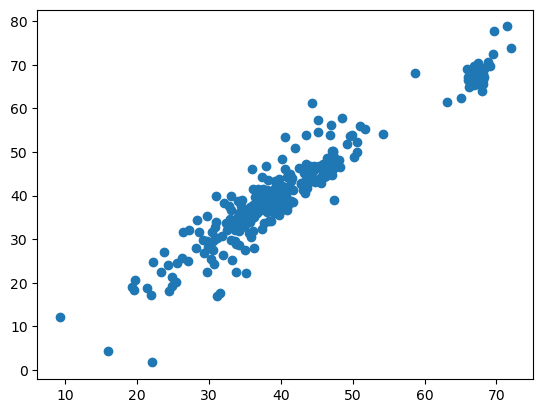

In [616]:
plt.scatter(mean_y_pred,mean_y_true)
csv_stacks

In [593]:
file.columns[300:]

Index(['OHEP_28_pos_7_T', 'OHEP_29_pos_8_A', 'OHEP_30_pos_8_C',
       'OHEP_31_pos_8_G', 'OHEP_32_pos_8_T', 'OHEP_33_pos_9_A',
       'OHEP_34_pos_9_C', 'OHEP_35_pos_9_G', 'OHEP_36_pos_9_T',
       'OHEP_37_pos_10_A', 'OHEP_38_pos_10_C', 'OHEP_39_pos_10_G',
       'OHEP_40_pos_10_T', 'OHEP_41_pos_11_A', 'OHEP_42_pos_11_C',
       'OHEP_43_pos_11_G', 'OHEP_44_pos_11_T', 'OHEP_45_pos_12_A',
       'OHEP_46_pos_12_C', 'OHEP_47_pos_12_G', 'OHEP_48_pos_12_T',
       'OHEP_49_pos_13_A', 'OHEP_50_pos_13_C', 'OHEP_51_pos_13_G',
       'OHEP_52_pos_13_T', 'OHEP_53_pos_14_A', 'OHEP_54_pos_14_C',
       'OHEP_55_pos_14_G', 'OHEP_56_pos_14_T', 'OHEP_57_pos_15_A',
       'OHEP_58_pos_15_C', 'OHEP_59_pos_15_G', 'OHEP_60_pos_15_T',
       'OHEP_61_pos_16_A', 'OHEP_62_pos_16_C', 'OHEP_63_pos_16_G',
       'OHEP_64_pos_16_T', 'OHEP_65_pos_17_A', 'OHEP_66_pos_17_C',
       'OHEP_67_pos_17_G', 'OHEP_68_pos_17_T', 'OHEP_69_pos_18_A',
       'OHEP_70_pos_18_C', 'OHEP_71_pos_18_G', 'OHEP_72_pos_18_T',
    

In [567]:
stats_stack.reset_index(drop=True).rename(columns={"index":"resample"}).describe()
# stats_stack.

,resample,r2,rmsd,bias,sdep,plot_a,plot_b,mse,mae
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,25.50000,0.879926,4.209823,-0.534454,4.148665,1.030948,-1.834564,18.057828,2.934574
std,14.57738,0.036346,0.584857,0.499431,0.568133,0.045784,2.075104,5.051730,0.351115
min,1.00000,0.779190,2.987493,-1.728595,2.965893,0.883948,-6.488141,8.925112,2.246179
25%,13.25000,0.861198,3.845186,-0.865549,3.809099,1.002471,-2.989852,14.785460,2.738471
50%,25.50000,0.886745,4.199823,-0.555774,4.137579,1.029416,-1.804703,17.638538,2.952223
75%,37.75000,0.904206,4.500979,-0.186846,4.454812,1.056984,-0.269687,20.259160,3.083044
max,50.00000,0.935251,5.712470,0.413563,5.591227,1.124582,4.635767,32.632309,3.896518


In [ ]:
for desc in desc_type:
    for prop in GSHT_list:
        units='N'
        model_name = f"1DConv_st_{prop}" 
        for set_type in set_types:
            stats_stack=pd.DataFrame()
            csv_stacks=pd.DataFrame()
            for resample in range(50):
                try:
                    directory_path = Path(f"{os.getcwd()}/CV/{resample}/{desc}/{model_name}/")
                    csv_name=f'{directory_path}/{set_type}.csv'
                    csv_df_stats,csv_df=plots(csv_name)
                    stats_stack=pd.concat([stats_stack,csv_df_stats],
                                            axis=0)
                    csv_stacks=pd.concat([csv_stacks,csv_df],
                                            axis=1)
                    result = pd.concat([csv_stacks, csv_df], axis=1, join='outer')
                except:
                    print(resample)
                    pass
            stats_describe=stats_stack.describe() 

### DEV

In [431]:
    
def plots(csv_name):

    csv_df_stats=pd.read_csv(f'{csv_name[:-4]}_stats.csv')
    csv_df=pd.read_csv(f'{csv_name[:-4]}.csv',index_col='ID')
    return csv_df_stats,csv_df

directory_path = Path(f"{os.getcwd()}/CV/{resample}/{desc}/{model_name}/")

set_types = ['train','val','test']
set_type = 'test'

stats_stack=pd.DataFrame()
csv_stacks=pd.DataFrame()
for resample in range(5):
    directory_path = Path(f"{os.getcwd()}/CV/{resample}/{desc}/{model_name}/")
    csv_name=f'{directory_path}/{set_type}.csv'
    csv_df_stats,csv_df=plots(csv_name)
    stats_stack=pd.concat([stats_stack,csv_df_stats],
                            axis=0)
    csv_stacks=pd.concat([csv_stacks,csv_df],
                            axis=1)
    result = pd.concat([csv_stacks, csv_df], axis=1, join='outer')
    
stats_stack
csv_stacks
result
csv_stacks

,index,y_true,y_pred,index,y_true,y_pred,index,y_true,y_pred,index,y_true,y_pred,index,y_true,y_pred
ID,,,,,,,,,,,,,,,
1,0.0,-46.3,-59.446934,0.0,-46.3,-60.083447,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-46.3,-58.675243
5,4.0,-55.4,-58.704082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,-55.4,-58.623340
6,5.0,-54.6,-57.756733,NaN,NaN,NaN,5.0,-54.6,-59.40774,5.0,-54.6,-57.0334,NaN,NaN,NaN
10,9.0,-50.2,-50.036663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,11.0,-89.9,-91.014854,NaN,NaN,NaN,11.0,-89.9,-90.46723,NaN,NaN,NaN,11.0,-89.9,-85.998830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245.0,-57.7,-60.730410
255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,-32.7,-46.057510
267,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266.0,-128.0,-117.075226


In [435]:
mean_y_pred = csv_stacks.filter(like='y_pred').mean(axis=1)
mean_y_pred
std_y_pred = csv_stacks.filter(like='y_pred').std(axis=1)
std_y_pred
mean_y_true = csv_stacks.filter(like='y_true').mean(axis=1)
mean_y_true

ID
1      -46.3
5      -55.4
6      -54.6
10     -50.2
12     -89.9
       ...  
246    -57.7
255    -32.7
267   -128.0
269   -120.4
300    -56.5
Length: 244, dtype: float64

In [427]:
stats_stack.describe()

,Unnamed: 0,resample,r2,rmsd,bias,sdep,plot_a,plot_b,mse,mae
count,5.0,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.0,2.000000,0.946600,5.042200,0.200400,30.152400,0.917800,-5.402000,25.617400,3.841000
std,0.0,1.581139,0.010991,0.491465,0.755824,1.228012,0.026013,2.476529,4.986507,0.316068
min,0.0,0.000000,0.936000,4.549000,-1.039000,28.644000,0.881000,-9.327000,20.692000,3.402000
25%,0.0,1.000000,0.940000,4.553000,0.074000,29.429000,0.901000,-6.298000,20.731000,3.772000
50%,0.0,2.000000,0.940000,5.196000,0.450000,29.916000,0.928000,-4.311000,26.998000,3.806000
75%,0.0,3.000000,0.958000,5.215000,0.604000,31.130000,0.936000,-3.835000,27.199000,3.949000
max,0.0,4.000000,0.959000,5.698000,0.913000,31.643000,0.943000,-3.239000,32.467000,4.276000


(-148.30499999999998, -22.574778619306567)

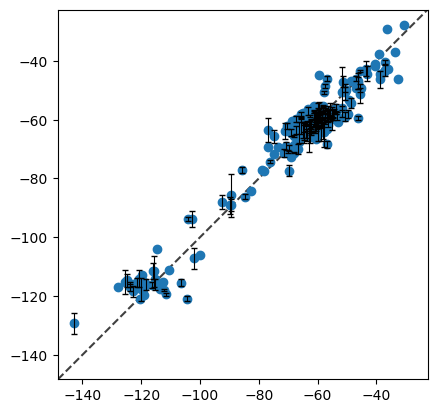

In [439]:
fig, ax = plt.subplots()   

plt.scatter(mean_y_true,mean_y_pred)
plt.errorbar(mean_y_true, mean_y_pred, yerr=std_y_pred, fmt='none',ecolor='black',elinewidth=0.8,capsize=2,
                    barsabove=False)

lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
           ]
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

In [443]:
stats_describe=stats_stack.describe()#['r2']['mean']
stats_describe['r2']['mean']

0.9466000000000001

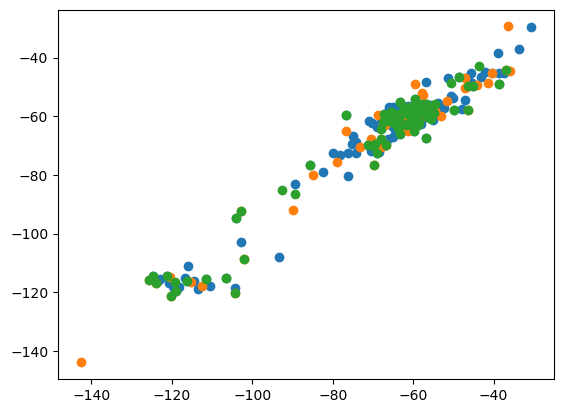

In [314]:

plt.scatter(csv_df_train['y_true'], csv_df_train['y_pred'],alpha=0.5)
plt.scatter(csv_df_val['y_true'], csv_df_val['y_pred'])
plt.scatter(csv_df['y_true'], csv_df['y_pred'])

In [455]:
plot_err(stats_stack,csv_stacks,model_name,prop,desc,set_type)

In [454]:
def plot_err(stats_stack,csv_stacks,model_name,prop,desc,set_type):
    
    model_name
    if prop == 'Tm':
        name = 'T'
    elif prop == 'dS':
        name = 'S'
    elif prop == 'dH':
        name = 'H'
    else:
        name = 'G'
    # name = prop
    descriptor_name = desc
    set_name=set_type
# Compute mean and std in pred, access true value, compute mean and std in stats
    y_pred_test = csv_stacks.filter(like='y_pred').mean(axis=1)
    yerr = csv_stacks.filter(like='y_pred').std(axis=1)
    y_test = csv_stacks.filter(like='y_true').mean(axis=1)
    stats_describe=stats_stack.describe()  
    
#     Load list

    # Average results over resamples:
    r2 = '{:.3f}'.format(stats_describe['r2']['mean'])
    rmsd = '{:.3f}'.format(stats_describe['rmsd']['mean'])
    bias = '{:.3f}'.format(stats_describe['bias']['mean'])
    sdep = '{:.3f}'.format(stats_describe['sdep']['mean'])
    # Sample Standard deviation results over resamples
    r2_sd = '{:.3f}'.format(stats_describe['r2']['std'])
    rmsd_sd = '{:.3f}'.format(stats_describe['rmsd']['std'])
    bias_sd = '{:.3f}'.format(stats_describe['bias']['std'])
    sdep_sd = '{:.3f}'.format(stats_describe['sdep']['std'])


    fig, ax = plt.subplots()   

     # Line of best fit
    try:
        a, b = np.polyfit(y_test, y_pred_test, 1)
        plot_a = '{:.3f}'.format(a)
        plot_b = '{:.3f}'.format(b)
    except np.linalg.LinAlgError:
        pass

    # Plot everything
    try:
#         Tab tittle
        if name=='T':
            plt.title(f'{model_name} | ${name}_m$ | {descriptor_name} | {set_name} set')
            plt.plot([], [], ' ', label=f'{model_name} | ${name}_m$ | {set_name} set')
        elif name=='S':
            plt.title(f'{model_name} | Δ{name} | {descriptor_name} | {set_name} set')
            plt.plot([], [], ' ', label=f'{model_name} | Δ{name} | {set_name} set')
        else:
            plt.title(f'{model_name} | Δ{name} | {descriptor_name} | {set_name} set')
            plt.plot([], [], ' ', label=f'{model_name} | Δ{name} | {set_name} set')

#         Stats
        plt.plot([], [], ' ', label=f'$R^{2}$ : {r2} $\pm$ {r2_sd} ')
        plt.plot([], [], ' ', label=f'RMSD : {rmsd} $\pm$ {rmsd_sd} ')
        plt.plot([], [], ' ', label=f'Bias : {bias} $\pm$ {bias_sd} ')
        plt.plot([], [], ' ', label=f'SDEP : {sdep} $\pm$ {sdep_sd} ')
#         provide information about the gradient
        plt.plot([], [], ' ', label=f'y = {plot_a}x + {plot_b}')       
#         plot scatter plot
        plt.scatter(y_test, y_pred_test)
#         Plot error bars
        plt.errorbar(y_test, y_pred_test, yerr=yerr, fmt='none',ecolor='black',elinewidth=0.8,capsize=2,
                    barsabove=False)
#     plot line of best fit
        plt.plot(y_test, a * y_test + b, color='purple')
        order = [0,1,2,3,4,5]
    except NameError:
        pass

    # x=y line
    lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
           ]
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    # Legend
#     Axis labes
    if name=='T':
        plt.xlabel(f' ${name}_m$ True (°C)')
        plt.ylabel(f' ${name}_m$ Pred (°C)')
    elif name=='S':
        plt.xlabel(f' Δ{name} True (cal/mol/K)')
        plt.ylabel(f' Δ{name} Pred (cal/mol/K)')
    else:
        plt.xlabel(f' Δ{name} True (kcal/mol)')
        plt.ylabel(f' Δ{name} Pred (kcal/mol)')
#     legend labels
    handles, labels = plt.gca().get_legend_handles_labels()
    leg = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
    leg.get_frame().set_linewidth(0.0)
#     Most crucail -> file name! 
    fig.savefig(f'Resamples_mean_std_{model_name}_{set_name}_{name}_{descriptor_name}.png', bbox_inches='tight', dpi=800)
#     clear and close fig
    plt.clf()
    plt.cla()
    plt.close(fig)

In [ ]:
def plot(trial_number,set_type):
    test=os.getcwd()+f'/trial_predictions/trial_predictions_{trial_number}_{set_type}plot.csv'
    df=pd.read_csv(test)
    df2=df
    y_test = df2[f'y_{string}']
    y_pred_test = df2[f'y_{string}_pred']
    y_test_np = y_test.to_numpy()
    y_pred_test_np = y_pred_test.to_numpy()
    r2_test = r2_score(y_test_np, y_pred_test_np)
    rmsd_test = (mean_squared_error(y_test_np, y_pred_test_np))**0.5
    bias_test = np.mean(y_pred_test_np - y_test_np)
    sdep_test = (np.mean((y_pred_test_np - y_test_np - bias_test)**2))**0.5
    r2_test = '{:.3f}'.format(r2_test)
    rmsd_test = '{:.3f}'.format(rmsd_test)
    bias_test = '{:.3f}'.format(bias_test)
    sdep_test = '{:.3f}'.format(sdep_test)

    fig, ax = plt.subplots()   

    # Line of best fit
    try:
        a, b = np.polyfit(df2[f'y_{string}'], df2[f'y_{string}_pred'], 1)
        plot_a = '{:.3f}'.format(a)
        plot_b = '{:.3f}'.format(b)
    except np.linalg.LinAlgError:
        pass

    # Plot everything
    try:
        plt.plot([], [], ' ', label=f'{set_type} set , trial {trial_number}'+f'{string}')
        plt.plot([], [], ' ', label=f'$R^{2}$ : {r2_test}')
        plt.plot([], [], ' ', label=f'RMSD : {rmsd_test}')
        plt.plot([], [], ' ', label=f'Bias : {bias_test}')
        plt.plot([], [], ' ', label=f'SDEP : {sdep_test}')
        plt.plot([], [], ' ', label=f'y = {plot_a}x + {plot_b}')
        plt.scatter(df2[f'y_{string}'], df2[f'y_{string}_pred'])
        plt.plot(df2[f'y_{string}'], a * df2[f'y_{string}'] + b, color='purple')
        order = [0,1,2,3,4,5]
    except NameError:
        pass

    # x=y line
    lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
           ]
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    # Legend
    plt.xlabel('$ΔH^{exp}_{solv}$ (kcal/mol)')
    plt.ylabel('$ΔH^{calc}_{solv}$ (kcal/mol)')
    handles, labels = plt.gca().get_legend_handles_labels()
    leg = plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
    leg.get_frame().set_linewidth(0.0)
    fig.savefig(f'{os.getcwd()}/trial_predictions/{string}_trial_{trial_number}.png', bbox_inches='tight', dpi=1000)
    plt.clf()
    plt.cla()
    plt.close(fig)

# Trouble shoot script template 4

In [351]:
# Code Execution 

df=pd.read_csv("Lomzov_dataset_IY.csv")
home=os.getcwd()
# data Generation
# cv_hp(df,home)

# Actual instrucitons
GSHT_list=['dH','dS','dG','Tm']
resample=0
fold=5
desc='Granulated'
prop = 'dH' 
model_name = f"1DConv_st_dH" 
epochs = 300
batch  = 16




In [352]:

#  ANALYSIS SCRIPT 
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from sklearn.metrics import mean_absolute_error
import sys

def stats_hp(y_test_pred, Y_test, prop):
    y_test_np = Y_test[f'{prop}'].to_numpy()
    y_pred_test_np = y_test_pred

    r2_test = r2_score(y_test_np, y_pred_test_np)
    rmsd_test = (mean_squared_error(y_test_np, y_pred_test_np))**0.5
    bias_test = np.mean(y_pred_test_np - y_test_np)
    sdep_test = (np.mean((y_pred_test_np - y_test_np - bias_test)**2))**0.5
    r2 = '{:.3f}'.format(r2_test)
    rmsd = '{:.3f}'.format(rmsd_test)
    bias = '{:.3f}'.format(bias_test)
    sdep = '{:.3f}'.format(sdep_test)
    
    
    mse=mean_squared_error(y_test_np, y_pred_test_np)
    mse='{:.3f}'.format(mse)
    mae=mean_absolute_error(y_test_np, y_pred_test_np)
    mae='{:.3f}'.format(mae)
    try:
        a, b = np.polyfit(y_test_np, y_pred_test_np, 1)
        plot_a = '{:.3f}'.format(a[0])
        plot_b = '{:.3f}'.format(b[0])
    except np.linalg.LinAlgError:
        pass
    
    return r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae

def grid_analysis(df,home,resample,fold,prop, model_name):
    df2=pd.DataFrame()
    keyList = ['trial',
               'model_type1', 'model_type',
               'layer_3_3', 'layer_2_2', 'layer_1',
               f'r2_{prop}_{fold}',
               f'rmsd_{prop}_{fold}',
               f'bias_{prop}_{fold}',
               f'SDEP_{prop}_{fold}',
               f'gradient_{prop}_{fold}',
               f'b_{prop}_{fold}',
               f'mse_{prop}_{fold}',
               f'mae_{prop}_{fold}']
    n = dict(zip(keyList, [None]*len(keyList)))
    
    df_grid=pd.DataFrame(n,index=['a'])
   
    dir=path_fold(home, resample, fold)
    # model_name = f"1DConv_st_{prop}" 
    tunner_path =f"{dir}/{desc}/{model_name}/tunner"
    tuner = kt.GridSearch(build_model,
                           objective=kt.Objective('val_loss', 'min'),
                            # loss = 'val_loss',
                           # objective = ['val_mse','epoch_entropy_pred_mse','val_free_energy_pred_mse'],
                          directory=tunner_path,
                          overwrite=False,
                          project_name=f'{batch}')

    # Find all trial number and cycle through them
    selection=os.listdir(tuner.project_dir)
    for dir_ in selection:
        if "trial_" not in dir_:
            continue
        trial_number=str(dir_.replace("trial_",""))
        trial=tuner.oracle.get_trial(trial_number)
        model=tuner.load_model(trial)

        # train, val, test = access_resample_csv(df,home,resample)
        train_fold, val_fold, test_fold = access_fold_csv(df,home,resample,fold)
        
        y_1_train, y_2_train, y_3_train, y_4_train, Y_train, X_padded_train, X_train = load_xy(train_fold,desc)
        y_1_val,   y_2_val,   y_3_val,   y_4_val,   Y_val,   X_padded_val,   X_val   = load_xy(val_fold,desc)
        y_1_test,  y_2_test,  y_3_test,  y_4_test,  Y_test,  X_padded_test,  X_test  = load_xy(test_fold,desc)

        y_test_pred = model.predict(X_padded_test)
        
        r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred, Y_test, prop)
        if trial_number in df_grid.index:
            n = df_grid.loc[trial_number].to_dict()
        n.update({"trial":trial_number,})
        n.update({f'r2_{prop}_{fold}':r2,f'rmsd_{prop}_{fold}': rmsd, 
                  f'bias_{prop}_{fold}': bias, f'SDEP_{prop}_{fold}': sdep,
                  f'gradient_{prop}_{fold}': plot_a, f'b_{prop}_{fold}': plot_b, 
                  f'mse_{prop}_{fold}':mse, f'mae_{prop}_{fold}':mae,})

        original_stdout = sys.stdout 	
        with open(f'{prop}_{fold}_{resample}.txt', 'w') as f:
            sys.stdout = f
            trial.display_hyperparameters()
            # Reset the standard output
            sys.stdout = original_stdout 
        f.close
        data = open(f'{prop}_{fold}_{resample}.txt', 'r').read()
        data_hyp_param=data.replace(': ','\n').split('\n')
        i_index=0
        while i_index+1 < len(data_hyp_param):
            n.update({data_hyp_param[i_index]:data_hyp_param[i_index+1]})
            i_index+=2
        os.system(f'rm {prop}_{fold}_{resample}.txt')

        df_grid.loc[f'{trial_number}']=n
    df_grid.to_csv(f'{dir}/{desc}/{model_name}/{prop}_{fold}.csv')
    # df_grid.to_csv(f'{prop}_{fold}.csv')
    return
# No longer needed this execution
# grid_analysis(df,home,resample,fold,prop,model_name)

####### Template for Archiving and Deleting Files

import tarfile
import os
from pathlib import Path
#  Create Archive and Delete Folders

def create_tar_archive(work_dir,files):
    # Create a tar.gz archive
    with tarfile.open(f"{work_dir}tuner_results.tar.gz", "w:gz") as archive:
        for file in files:
            archive.add(f"{work_dir}{file}", arcname=os.path.basename(f"{file}"))
        archive.close()

        
def archive_hyper_params(home,resample,fold,prop,desc,model_name):
    # prop not required
    dir=path_fold(home, resample, fold)
    folder_dir=f'{dir}/{desc}/{model_name}/'
    folders_to_archive=os.listdir(folder_dir)
    create_tar_archive(folder_dir, folders_to_archive)
    
    return

def delete_folders_after_archive(home,resample,fold,prop,desc,model_name):
    # prop not required
    dir=path_fold(home, resample, fold)
    folder_dir=f'{dir}/{desc}/{model_name}/'
    folders_to_archive=os.listdir(folder_dir)
    folders_to_archive = list(filter(lambda i:'.' not in i, folders_to_archive))
    for folder in folders_to_archive:
        os.system(f'rm -r {folder_dir}{folder}')

    return
# no longer need execution  
# archive_hyper_params(home,resample,fold,prop,desc,model_name)
# delete_folders_after_archive(home,resample,fold,prop,desc,model_name)


In [353]:

# ######## Find best hyper params and train and evaluation on resample data
train, val, test = access_resample_csv(df,home,resample)

y_1_train, y_2_train, y_3_train, y_4_train, Y_train, X_padded_train, X_train = load_xy(train,desc)
y_1_val,   y_2_val,   y_3_val,   y_4_val,   Y_val,   X_padded_val,   X_val   = load_xy(val,desc)
y_1_test,  y_2_test,  y_3_test,  y_4_test,  Y_test,  X_padded_test,  X_test  = load_xy(test,desc)

fold_path = path_fold(home,resample,fold)
resample_path = path_resample(home,resample)

In [385]:

df_combine = pd.DataFrame()
df_summary = pd.DataFrame()
df_combine_all = pd.DataFrame()

# for resample in range(1):
df_combine_all = pd.DataFrame()
df_summary = pd.DataFrame()
# for prop in GSHT_list:
#     print(prop)
for fold in range(5):
    dir = path_fold(home, resample, fold)
    model_name = f"1DConv_st_{prop}"
    try:
        df_read=pd.read_csv(f'{dir}/{desc}/{model_name}/{prop}_{fold}.csv')
        # Combine
        df_combine=pd.concat([df_combine,df_read],
                            axis=1)
    except:
        pass
        
    # count=0
df_combine = df_combine.T.drop_duplicates().T
stats_list=['r2','rmsd','bias','SDEP','gradient','b','mse','mae']
for stat in stats_list:
    columns_to_compute = df_combine.filter(regex=f'^{stat}_{prop}')
    # print(columns_to_compute)
    # Compute mean and std for the specified columns
    mean_values = df_combine.filter(regex=f'^{stat}_{prop}').mean(axis=1)
    std_values = df_combine.filter(regex=f'^{stat}_{prop}').std(axis=1)
    df_combine_all[f'{stat}_{prop}_mean'] = mean_values
    df_combine_all[f'{stat}_{prop}_std']  = std_values
    if stat == 'r2' or stat =='rmsd':
        df_summary[f'{stat}_{prop}_mean'] = mean_values
        df_summary[f'{stat}_{prop}_std']  = std_values

df_summary['trial_id']=df_combine['Unnamed: 0']
#  Find the trial number with the best hyper paramteres
trial_number_fin_model = df_summary.loc[df_summary[f'r2_{prop}_mean'].idxmax()]['trial_id']

# Load best hyper parameters into a dataframe
best_hps=df_combine.loc[df_combine['Unnamed: 0']==trial_number_fin_model][df_combine.columns[1:8]]


In [405]:

df_combine = pd.DataFrame()
df_summary = pd.DataFrame()
df_combine_all = pd.DataFrame()

# for resample in range(1):
df_combine_all = pd.DataFrame()
df_summary = pd.DataFrame()
# for prop in GSHT_list:
#     print(prop)
for fold in range(5):
    dir = path_fold(home, resample, fold)
    model_name = f"1DConv_st_{prop}"
    try:
        df_read=pd.read_csv(f'{dir}/{desc}/{model_name}/{prop}_{fold}.csv')
        # Combine
        df_combine=pd.concat([df_combine,df_read],
                            axis=1)
    except:
        pass

In [406]:
# df_combine = df_combine.T.drop_duplicates().T
df_combine.columns

Index(['Unnamed: 0', 'trial', 'model_type1', 'model_type', 'layer_3_3',
       'layer_2_2', 'layer_1', 'r2_dH_0', 'rmsd_dH_0', 'bias_dH_0',
       'SDEP_dH_0', 'gradient_dH_0', 'b_dH_0', 'mse_dH_0', 'mae_dH_0',
       'Unnamed: 0', 'trial', 'model_type1', 'model_type', 'layer_3_3',
       'layer_2_2', 'layer_1', 'r2_dH_1', 'rmsd_dH_1', 'bias_dH_1',
       'SDEP_dH_1', 'gradient_dH_1', 'b_dH_1', 'mse_dH_1', 'mae_dH_1',
       'Unnamed: 0', 'trial', 'model_type1', 'model_type', 'layer_3_3',
       'layer_2_2', 'layer_1', 'r2_dH_2', 'rmsd_dH_2', 'bias_dH_2',
       'SDEP_dH_2', 'gradient_dH_2', 'b_dH_2', 'mse_dH_2', 'mae_dH_2',
       'Unnamed: 0', 'trial', 'model_type1', 'model_type', 'layer_3_3',
       'layer_2_2', 'layer_1', 'r2_dH_3', 'rmsd_dH_3', 'bias_dH_3',
       'SDEP_dH_3', 'gradient_dH_3', 'b_dH_3', 'mse_dH_3', 'mae_dH_3',
       'Unnamed: 0', 'trial', 'model_type1', 'model_type', 'layer_3_3',
       'layer_2_2', 'layer_1', 'r2_dH_4', 'rmsd_dH_4', 'bias_dH_4',
       'SDEP_dH_

In [407]:
stats_list=['r2','rmsd','bias','SDEP','gradient','b','mse','mae']
for stat in stats_list:
    columns_to_compute = df_combine.filter(regex=f'^{stat}_{prop}')
    # print(columns_to_compute)
    # Compute mean and std for the specified columns
    mean_values = df_combine.filter(regex=f'^{stat}_{prop}').mean(axis=1)
    std_values = df_combine.filter(regex=f'^{stat}_{prop}').std(axis=1)
    df_combine_all[f'{stat}_{prop}_mean'] = mean_values
    df_combine_all[f'{stat}_{prop}_std']  = std_values
    if stat == 'r2' or stat =='rmsd':
        df_summary[f'{stat}_{prop}_mean'] = mean_values
        df_summary[f'{stat}_{prop}_std']  = std_values

In [408]:
df_combine_clean = df_combine.loc[:,~df_combine.columns.duplicated()].copy()
df_combine_clean

,Unnamed: 0,trial,model_type1,model_type,layer_3_3,layer_2_2,layer_1,r2_dH_0,rmsd_dH_0,bias_dH_0,...,mse_dH_3,mae_dH_3,r2_dH_4,rmsd_dH_4,bias_dH_4,SDEP_dH_4,gradient_dH_4,b_dH_4,mse_dH_4,mae_dH_4
0,a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000,0.0,CNN3,Dense3,16.0,16.0,16.0,0.938,5.509,-1.793,...,27.146,3.921,0.915,6.863,1.548,32.630,0.918,-4.241,47.101,5.297
2,0007,7.0,CNN2,Dense3,16.0,128.0,16.0,0.938,5.472,-1.084,...,22.354,3.744,0.916,6.847,2.136,32.808,0.931,-2.757,46.885,5.545
3,0002,2.0,CNN3,Dense3,16.0,64.0,16.0,0.945,5.187,-1.140,...,29.875,4.112,0.919,6.712,0.656,32.870,0.933,-4.125,45.050,5.104
4,0010,10.0,CNN1,Dense3,16.0,64.0,16.0,0.933,5.717,-1.178,...,29.931,4.385,0.917,6.777,0.842,33.159,0.949,-2.757,45.933,5.027
5,0003,3.0,CNN3,Dense3,16.0,128.0,16.0,0.926,6.009,-1.582,...,31.746,4.344,0.911,7.049,2.157,32.621,0.918,-3.691,49.687,5.740
6,0004,4.0,CNN2,Dense3,16.0,16.0,16.0,0.944,5.220,-0.606,...,30.530,4.427,0.912,7.008,2.060,32.247,0.896,-5.329,49.107,5.721
7,0001,1.0,CNN3,Dense3,16.0,32.0,16.0,0.935,5.640,-1.602,...,25.336,3.904,0.920,6.686,0.666,32.275,0.898,-6.569,44.705,5.039
8,0006,6.0,CNN2,Dense3,16.0,64.0,16.0,0.943,5.250,-1.542,...,25.052,3.787,0.909,7.101,1.659,33.782,0.985,0.567,50.418,5.432
9,0009,9.0,CNN1,Dense3,16.0,32.0,16.0,0.931,5.777,-0.095,...,21.203,3.509,0.917,6.803,1.354,32.951,0.938,-3.076,46.275,5.170


In [409]:
df_combine_clean.columns

Index(['Unnamed: 0', 'trial', 'model_type1', 'model_type', 'layer_3_3',
       'layer_2_2', 'layer_1', 'r2_dH_0', 'rmsd_dH_0', 'bias_dH_0',
       'SDEP_dH_0', 'gradient_dH_0', 'b_dH_0', 'mse_dH_0', 'mae_dH_0',
       'r2_dH_1', 'rmsd_dH_1', 'bias_dH_1', 'SDEP_dH_1', 'gradient_dH_1',
       'b_dH_1', 'mse_dH_1', 'mae_dH_1', 'r2_dH_2', 'rmsd_dH_2', 'bias_dH_2',
       'SDEP_dH_2', 'gradient_dH_2', 'b_dH_2', 'mse_dH_2', 'mae_dH_2',
       'r2_dH_3', 'rmsd_dH_3', 'bias_dH_3', 'SDEP_dH_3', 'gradient_dH_3',
       'b_dH_3', 'mse_dH_3', 'mae_dH_3', 'r2_dH_4', 'rmsd_dH_4', 'bias_dH_4',
       'SDEP_dH_4', 'gradient_dH_4', 'b_dH_4', 'mse_dH_4', 'mae_dH_4'],
      dtype='object')

In [414]:
df_summary['trial_id']=df_combine_clean['Unnamed: 0']
#  Find the trial number with the best hyper paramteres
trial_number_fin_model = df_summary.loc[df_summary[f'r2_{prop}_mean'].idxmax()]['trial_id']

# Load best hyper parameters into a dataframe
best_hps=df_combine_clean.loc[df_combine_clean['Unnamed: 0']==trial_number_fin_model][df_combine.columns[2:7]]

In [415]:
best_hps

,model_type1,model_type,layer_3_3,layer_2_2,layer_1
7,CNN3,Dense3,16.0,32.0,16.0


In [359]:
trial_number_fin_model

'0001'

In [360]:
df_summary

,r2_dH_mean,r2_dH_std,rmsd_dH_mean,rmsd_dH_std,trial_id
0,NaN,NaN,NaN,NaN,a
1,0.915,0.016882,6.1726,1.084398,0000
2,0.921,0.014832,5.932,0.833571,0007
3,0.919,0.021296,5.9652,0.82774,0002
4,0.9148,0.017326,6.1428,0.702311,0010
5,0.9134,0.020623,6.1648,0.594373,0003
6,0.915,0.021424,6.1254,0.906978,0004
7,0.9256,0.014206,5.757,0.71669,0001
8,0.9168,0.015287,6.1022,1.064208,0006
9,0.9222,0.005541,5.9356,0.919673,0009


In [416]:

# Load Hyper parameters for final model
hp = kt.HyperParameters()

model_type1 = hp.Choice("model_type1", [best_hps.values[0, 0]])
model_type = hp.Choice("model_type", [best_hps.values[0, 1]])
hp_layer_1= hp.Choice(f'layer_1', values=[best_hps.values[0, 4]])
hp_layer_2_2= hp.Choice(f'layer_2_2', values=[best_hps.values[0, 3]])
hp_layer_3_3= hp.Choice(f'layer_3_3',  values=[best_hps.values[0, 2]])

# Build final model
test_model=build_model(hp)

# Inputs for training final Model
epochs = 300
# batch  = 16
# TODO: Use path lib to create path
resample_path = path_resample(home,resample)

# model_name = architecture of - Single task/RF/KNN + dH/dG/dS/Tm or - Multitask  
# prop = 'dH' 
# model_name = f"1DConv_st_{prop}" 


# Define the directory path
directory_path = Path(f"{os.getcwd()}/CV/{resample}/{desc}/{model_name}/")

# Define Paths for call backs
csv_logger_path  = Path(f'{directory_path}/csv_logger/')
cp_callback_path = Path(f'{directory_path}/model_checkpoint/')
tensorboard_path = Path(f'{directory_path}/tensorboard_logs/')

# Ensure the directory exists, create it if necessary
csv_logger_path.mkdir(parents=True, exist_ok=True)
cp_callback_path.mkdir(parents=True, exist_ok=True)
tensorboard_path.mkdir(parents=True, exist_ok=True)


#### CALL BACKS!
es = EarlyStopping(monitor      = 'val_loss', 
                        mode     = 'min', 
                        verbose  = 1, 
                        patience = 2000, 
                    restore_best_weights = True)
# CSV Logger
csv_logger = CSVLogger(f'{csv_logger_path}/model_history.csv' , append=True)

# CP_callbacks      not required when using a tunner       
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'{cp_callback_path}/cp.ckpt',
#                                                  save_weights_only=True,
#                                                  verbose=1)

# TensorBoard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path, 
                                                       #/{batch}', # _ADAPTIVELEARNIGNRATE_01_10_Dense3_64_3CNN_lr_3_es
                                                      update_freq = 1,
                                                      # histogram_freq=1, 
                                                      write_graph=False, 
                                                      write_images=False)
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard

# Covert to list and provide to Keras Regressor
keras_callbacks = [es, csv_logger, tensorboard_callback]

# Load resample data
y_1_train, y_2_train, y_3_train, y_4_train, Y_train, X_padded_train, X_train = load_xy(train,desc)
y_1_val,   y_2_val,   y_3_val,   y_4_val,   Y_val,   X_padded_val,   X_val   = load_xy(val,desc)
y_1_test,  y_2_test,  y_3_test,  y_4_test,  Y_test,  X_padded_test,  X_test  = load_xy(test,desc)

# Train model on resample data

ys_train = [y_1_train,y_2_train,y_3_train,y_4_train] 
ys_val   = [y_1_val,y_2_val,y_3_val,y_4_val]
ys_test  = [y_1_test,y_2_test,y_3_test,y_4_test]
GSHT_list.index(f'{prop}')+1

hp = kt.HyperParameters()

model_type1 = hp.Choice("model_type1", [best_hps.values[0, 0]])
model_type = hp.Choice("model_type", [best_hps.values[0, 1]])
hp_layer_1= hp.Choice(f'layer_1', values=[best_hps.values[0, 4]])
hp_layer_2_2= hp.Choice(f'layer_2_2', values=[best_hps.values[0, 3]])
hp_layer_3_3= hp.Choice(f'layer_3_3',  values=[best_hps.values[0, 2]])

# Build final model
test_model=build_model(hp)

history=test_model.fit(X_padded_train, ys_train[GSHT_list.index(f'{prop}')],
            epochs = epochs,
            batch_size=batch,
            verbose = 2,
            validation_data =(X_padded_val, ys_val[GSHT_list.index(f'{prop}')]),
             # validation_split = 0.2,
            callbacks=keras_callbacks)
# Make predictions


# Store stats


# Store csv files (predictions vs true)




Epoch 1/300
10/10 - 2s - loss: 4976.3125 - mse: 4976.3125 - mean_absolute_error: 67.2766 - r2_func_tf: -1.2733e+01 - rmse_func_tf: 69.9794 - bias_func_tf: -6.7165e+01 - sdep_func_tf: 19.3283 - val_loss: 1481.1564 - val_mse: 1481.1564 - val_mean_absolute_error: 36.5277 - val_r2_func_tf: -2.4899e+00 - val_rmse_func_tf: 38.2729 - val_bias_func_tf: -3.6528e+01 - val_sdep_func_tf: 11.2423 - 2s/epoch - 242ms/step
Epoch 2/300
10/10 - 0s - loss: 3354.4141 - mse: 3354.4141 - mean_absolute_error: 54.5599 - r2_func_tf: -9.0656e+00 - rmse_func_tf: 58.0793 - bias_func_tf: -5.5258e+01 - sdep_func_tf: 17.5306 - val_loss: 560.8002 - val_mse: 560.8002 - val_mean_absolute_error: 20.6930 - val_r2_func_tf: -5.2236e-01 - val_rmse_func_tf: 23.4852 - val_bias_func_tf: 20.5847 - val_sdep_func_tf: 10.8698 - 102ms/epoch - 10ms/step
Epoch 3/300
10/10 - 0s - loss: 843.2722 - mse: 843.2722 - mean_absolute_error: 21.9748 - r2_func_tf: -6.2227e-01 - rmse_func_tf: 24.1318 - bias_func_tf: -1.9993e+01 - sdep_func_tf: 1

In [369]:
ys_val[GSHT_list.index(f'{prop}')]
ys_val[GSHT_list.index(f'{prop}')]
# ys_val[0]

array([ -46.3,  -55.4,  -89.9,  -59.8,  -78.9,  -62.8,  -51.7,  -60.7,
        -69.7,  -44.2,  -54.6,  -37. ,  -59.3,  -66.9,  -58.6,  -68. ,
        -53.1,  -58.6,  -47. ,  -73.3,  -69.6,  -66.8,  -70.6,  -67.9,
       -102. , -115.2, -125.6, -123.9,  -60.5,  -84.8,  -57.7,  -41.4,
        -62.1,  -36.3, -102.8,  -46.4, -112.4, -104.4,  -60.3,  -76.7,
        -47. ,  -62.6,  -40.4,  -35.9,  -56.8,  -57.7, -120.5,  -55.6,
       -120.2,  -59.7,  -56.1,  -57.5,  -67.4,  -68.8, -142.7,  -64.3,
        -61. ,  -61.4,  -62.3,  -60.4,  -63.1,  -66.4,  -59.3,  -59.6])

In [381]:
history.params
history.model
history.validation_data
# history.history
test_model.get_config()
hp = kt.HyperParameters()

model_type1 = hp.Choice("model_type1", [best_hps.values[0, 0]])
model_type = hp.Choice("model_type", [best_hps.values[0, 1]])
hp_layer_1= hp.Choice(f'layer_1', values=[best_hps.values[0, 4]])
hp_layer_2_2= hp.Choice(f'layer_2_2', values=[best_hps.values[0, 3]])
hp_layer_3_3= hp.Choice(f'layer_3_3',  values=[best_hps.values[0, 2]])

# Build final model
# test_model=build_model(hp)
hp_layer_3_3
best_hps

,model_type1,model_type,layer_3_3,layer_2_2,r2_dH_0
7,CNN3,Dense3,16.0,32.0,0.935


In [ ]:
def stats_csv(y_test_pred, Y_test, prop, csv_name, set_type,resample):
    y_test_np = Y_test[f'{prop}'].to_numpy()
    y_pred_test_np = y_test_pred

    r2_test = r2_score(y_test_np, y_pred_test_np)
    rmsd_test = (mean_squared_error(y_test_np, y_pred_test_np))**0.5
    bias_test = np.mean(y_pred_test_np - y_test_np)
    sdep_test = (np.mean((y_pred_test_np - y_test_np - bias_test)**2))**0.5
    r2 = '{:.3f}'.format(r2_test)
    rmsd = '{:.3f}'.format(rmsd_test)
    bias = '{:.3f}'.format(bias_test)
    sdep = '{:.3f}'.format(sdep_test)
    
    
    mse=mean_squared_error(y_test_np, y_pred_test_np)
    mse='{:.3f}'.format(mse)
    mae=mean_absolute_error(y_test_np, y_pred_test_np)
    mae='{:.3f}'.format(mae)
    try:
        a, b = np.polyfit(y_test_np, y_pred_test_np, 1)
        plot_a = '{:.3f}'.format(a[0])
        plot_b = '{:.3f}'.format(b[0])
    except np.linalg.LinAlgError:
        pass
        # 'index':np.array(Y_test.index),'ID':np.array(Y_test.index +1),
    y_pred_test_np = y_test_pred.squeeze()
    csv_df=pd.DataFrame({'index':np.array(Y_test.index),'ID':np.array(Y_test.index +1),'y_true': y_test_np, 'y_pred': y_pred_test_np})
    csv_df.to_csv(csv_name,index=None)

    csv_df_stats=pd.DataFrame(data=np.array([[resample, r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae]]),
                              # index=None, 
                              columns=['resample','r2','rmsd', 'bias', 'sdep', 'plot_a', 'plot_b', 'mse', 'mae'])
    csv_df_stats.to_csv(f'{csv_name[:-4]}_stats.csv',mode='a',index='resample')
    
    return csv_df



set_types = ['train','val','test']
# set_type = 'test'
# csv_name=f'{directory_path}/{set_type}.csv'
# csv_name=f'{set_type}.csv'

list_indexes = [train, val, test]
index_counter=-1
for indexes in list_indexes:
    index_counter+=1
    csv_name=f'{directory_path}/{set_types[index_counter]}.csv'
    y_1,  y_2,  y_3,  y_4,  Y,  X_padded,  X  = load_xy(indexes,desc)
    predictions = test_model.predict(X_padded)
    csv_df = stats_csv(predictions, Y, prop, csv_name, set_types[index_counter],resample)


## Analysis on Resample -> Test, train, val / True vs Predicted (CSV) / Store Stats (CSV). 

In [340]:
# trial_number_fin_model = df_summary.loc[df_summary[f'r2_{prop}_mean'].idxmax()]['trial_id']
df_read=pd.read_csv(f'{dir}/{desc}/{model_name}/{prop}_{fold}.csv')
df_read
f'{dir}/{desc}/{model_name}/{prop}_{fold}.csv'

'/users/qdb16186/CNN_stk/CV/0/4/Granulated/1DConv_st_dH/dH_4.csv'

In [344]:
prop='Tm'
GSHT_list.index(f'{prop}')+1
# prop

4

In [336]:
df_combine = pd.DataFrame()
df_summary = pd.DataFrame()
df_combine_all = pd.DataFrame()

df_combine_all = pd.DataFrame()
df_summary = pd.DataFrame()
for prop in GSHT_list[0:1]:
    print(prop)
for fold in range(5):
    dir = path_fold(home, resample, fold)
    model_name = f"1DConv_st_{prop}"
    try:
        df_read=pd.read_csv(f'{dir}/{desc}/{model_name}/{prop}_{fold}.csv')
        # Combine
        df_combine=pd.concat([df_combine,df_read],
                            axis=1)
    except:
        pass
print(df_combine)    
    # count=0
df_combine = df_combine.T.drop_duplicates().T
stats_list=['r2','rmsd','bias','SDEP','gradient','b','mse','mae']
for stat in stats_list:
    columns_to_compute = df_combine.filter(regex=f'^{stat}_{prop}')
    # print(columns_to_compute)
    # Compute mean and std for the specified columns
    mean_values = df_combine.filter(regex=f'^{stat}_{prop}').mean(axis=1)
    std_values = df_combine.filter(regex=f'^{stat}_{prop}').std(axis=1)
    df_combine_all[f'{stat}_{prop}_mean'] = mean_values
    df_combine_all[f'{stat}_{prop}_std']  = std_values
    if stat == 'r2' or stat =='rmsd':
        df_summary[f'{stat}_{prop}_mean'] = mean_values
        df_summary[f'{stat}_{prop}_std']  = std_values

df_summary['trial_id']=df_combine['Unnamed: 0']
#  Find the trial number with the best hyper paramteres
trial_number_fin_model = df_summary.loc[df_summary[f'r2_{prop}_mean'].idxmax()]['trial_id']

# Load best hyper parameters into a dataframe
best_hps=df_combine.loc[df_combine['Unnamed: 0']==trial_number_fin_model][df_combine.columns[2:7]]


dH
  Unnamed: 0  trial  model_type1  model_type  layer_3_3  layer_2_2  layer_1  \
0          a    NaN          NaN         NaN        NaN        NaN      NaN   

   r2_dH_0  rmsd_dH_0  bias_dH_0  ...  layer_2_2  layer_1  r2_dH_4  rmsd_dH_4  \
0      NaN        NaN        NaN  ...        NaN      NaN      NaN        NaN   

   bias_dH_4 SDEP_dH_4  gradient_dH_4  b_dH_4  mse_dH_4  mae_dH_4  
0        NaN       NaN            NaN     NaN       NaN       NaN  

[1 rows x 75 columns]


/tmp/ipykernel_1706250/748949086.py:37: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  trial_number_fin_model = df_summary.loc[df_summary[f'r2_{prop}_mean'].idxmax()]['trial_id']


KeyError: nan

# Other

{}

In [187]:
hp.values

{'model_type1': 'CNN1',
 'model_type': 'Dense3',
 'layer_1': 64.0,
 'layer_2_2': 128.0,
 'layer_3_3': 64.0}

In [ ]:
    keyList = ['trial',
                 'model_type1',
                 'model_type',
                     'layer_3_3',
                     'layer_2_2',
                     'layer_1',
               'r2_dH_0','rmsd_dH_0','bias_dH_0','SDEP_dH_0','gradient_dH_0','b_dH_0','mse_dH_0','mae_dH_0',
               'r2_dH_1','rmsd_dH_1','bias_dH_1','SDEP_dH_1','gradient_dH_1','b_dH_1','mse_dH_1','mae_dH_1',
               'r2_dH_2','rmsd_dH_2','bias_dH_2','SDEP_dH_2','gradient_dH_2','b_dH_2','mse_dH_2','mae_dH_2',
               'r2_dH_3','rmsd_dH_3','bias_dH_3','SDEP_dH_3','gradient_dH_3','b_dH_3','mse_dH_3','mae_dH_3',
               'r2_dH_4','rmsd_dH_4','bias_dH_4','SDEP_dH_4','gradient_dH_4','b_dH_4','mse_dH_4','mae_dH_4',
               'r2_dH_mean','rmsd_dH_mean','bias_dH_mean','SDEP_dH_mean','gradient_dH_mean','b_dH_mean','mse_dH_mean','mae_dH_mean',
               'r2_dH_std','rmsd_dH_std','bias_dH_std','SDEP_dH_std','gradient_dH_std','b_dH_std','mse_dH_std','mae_dH_std',
               
               'r2_dS_0','rmsd_dS_0','bias_dS_0','SDEP_dS_0','gradient_dS_0','b_dS_0','mse_dS_0','mae_dS_0',
               'r2_dS_1','rmsd_dS_1','bias_dS_1','SDEP_dS_1','gradient_dS_1','b_dS_1','mse_dS_1','mae_dS_1',
               'r2_dS_2','rmsd_dS_2','bias_dS_2','SDEP_dS_2','gradient_dS_2','b_dS_2','mse_dS_2','mae_dS_2',
               'r2_dS_3','rmsd_dS_3','bias_dS_3','SDEP_dS_3','gradient_dS_3','b_dS_3','mse_dS_3','mae_dS_3',
               'r2_dS_4','rmsd_dS_4','bias_dS_4','SDEP_dS_4','gradient_dS_4','b_dS_4','mse_dS_4','mae_dS_4',
               'r2_dS_mean','rmsd_dS_mean','bias_dS_mean','SDEP_dS_mean','gradient_dS_mean','b_dS_mean','mse_dS_mean','mae_dS_mean',
               'r2_dS_std','rmsd_dS_std','bias_dS_std','SDEP_dS_std','gradient_dS_std','b_dS_std','mse_dS_std','mae_dS_std',
               
               'r2_dG_0','rmsd_dG_0','bias_dG_0','SDEP_dG_0','gradient_dG_0','b_dG_0','mse_dG_0','mae_dG_0',
               'r2_dG_1','rmsd_dG_1','bias_dG_1','SDEP_dG_1','gradient_dG_1','b_dG_1','mse_dG_1','mae_dG_1',
               'r2_dG_2','rmsd_dG_2','bias_dG_2','SDEP_dG_2','gradient_dG_2','b_dG_2','mse_dG_2','mae_dG_2',
               'r2_dG_3','rmsd_dG_3','bias_dG_3','SDEP_dG_3','gradient_dG_3','b_dG_3','mse_dG_3','mae_dG_3',
               'r2_dG_4','rmsd_dG_4','bias_dG_4','SDEP_dG_4','gradient_dG_4','b_dG_4','mse_dG_4','mae_dG_4',
               'r2_dG_mean','rmsd_dG_mean','bias_dG_mean','SDEP_dG_mean','gradient_dG_mean','b_dG_mean','mse_dG_mean','mae_dG_mean',
               'r2_dG_std','rmsd_dG_std','bias_dG_std','SDEP_dG_std','gradient_dG_std','b_dG_std','mse_dG_std','mae_dG_std',

               'r2_Tm_0','rmsd_Tm_0','bias_Tm_0','SDEP_Tm_0','gradient_Tm_0','b_Tm_0','mse_Tm_0','mae_Tm_0',
               'r2_Tm_1','rmsd_Tm_1','bias_Tm_1','SDEP_Tm_1','gradient_Tm_1','b_Tm_1','mse_Tm_1','mae_Tm_1',
               'r2_Tm_2','rmsd_Tm_2','bias_Tm_2','SDEP_Tm_2','gradient_Tm_2','b_Tm_2','mse_Tm_2','mae_Tm_2',
               'r2_Tm_3','rmsd_Tm_3','bias_Tm_3','SDEP_Tm_3','gradient_Tm_3','b_Tm_3','mse_Tm_3','mae_Tm_3',
               'r2_Tm_4','rmsd_Tm_4','bias_Tm_4','SDEP_Tm_4','gradient_Tm_4','b_Tm_4','mse_Tm_4','mae_Tm_4',
               'r2_Tm_mean','rmsd_Tm_mean','bias_Tm_mean','SDEP_Tm_mean','gradient_Tm_mean','b_Tm_mean','mse_Tm_mean','mae_Tm_mean',
               'r2_Tm_std','rmsd_Tm_std','bias_Tm_std','SDEP_Tm_std','gradient_Tm_std','b_Tm_std','mse_Tm_std','mae_Tm_std',
              ]
    n = dict(zip(keyList, [None]*len(keyList)))
    df_grid=pd.DataFrame(n,index=['a'])

In [ ]:
n

In [ ]:
df=pd.read_csv("Lomzov_dataset_IY.csv")
home=os.getcwd()
resample=4
fold=4
train, val, test = access_resample_csv(df,home,resample)
train_fold, val_fold, test_fold = access_fold_csv(df,home,resample,fold)

y_1_train, y_2_train, y_3_train, y_4_train, Y_train, X_padded_train, X_train = load_xy(train_fold,desc)
y_1_val,   y_2_val,   y_3_val,   y_4_val,   Y_val,   X_padded_val,   X_val   = load_xy(val_fold,desc)
y_1_test,  y_2_test,  y_3_test,  y_4_test,  Y_test,  X_padded_test,  X_test  = load_xy(test_fold,desc)



tunner_path =f"{dir}/{desc}/{model_name}/tunner"
tuner = kt.GridSearch(build_model,
                   objective=kt.Objective('val_loss', 'min'),
                    # loss = 'val_loss',
                   # objective = ['val_mse','epoch_entropy_pred_mse','val_free_energy_pred_mse'],
                  direcddstory=tunner_path,
                  overwrite=False,
                  project_name=f'{batch}')
trial_number='0036'
trial=tuner.oracle.get_trial(trial_number)
model=tuner.load_model(trial)
y_test_pred = model.predict(X_padded_test)
# Calc stats and Store predicitons only for the best model
y_test_pred
Y_test
prop

r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats_hp(y_test_pred, Y_test, prop)


In [106]:
r2

'0.951'

In [ ]:
tuner = kt.GridSearch(build_model,
                                   objective=kt.Objective('val_loss', 'min'),
                                    # loss = 'val_loss',
                                   # objective = ['val_mse','epoch_entropy_pred_mse','val_free_energy_pred_mse'],
                                  directory=f'{path}/hyper_param_tunning_tunner_fold_{i_fold}',
                                  overwrite=False,
                                  project_name=f'{batch}')
        # Find all trial number and cycle through them
        selection=os.listdir(tuner.project_dir)
        for dir_ in selection:
            if "trial_" not in dir_:
                continue
            # trial_number='0036'
            trial_number=str(dir_.replace("trial_",""))
            trial=tuner.oracle.get_trial(trial_number)
            model=tuner.load_model(trial)
            
            y_pred_train_cv = model.predict(x_fold_test)
            y_pred_train_cv_enthalpy = y_pred_train_cv[0].squeeze()
y_train_resample_output = pd.DataFrame()
            y_train_resample_output['ID'] = train_idx[fold_test_index]
            # y_train_resample_output['Temp'] = train_resample['Temp']
            
            y_train_resample_output['y_dH'] = y_fold_test[0]
y_train_resample_output["y_dH_pred"]=y_pred_train_cv_enthalpy
y_train_resample_output.to_csv(f'{path}/true_pred_fold_{i_fold}_trial_{trial_number}.csv')
            for string in GSHT_list:
                r2, rmsd, bias, sdep, plot_a, plot_b, mse, mae = stats(y_train_resample_output,string)
                if trial_number in df_grid.index:
                    n = df_grid.loc[trial_number].to_dict()
                # else:
                # n = df.loc[trial_number].to_dict() if trial_number in df_grid.index else {}
                n.update({"trial":trial_number,})
                n.update({f'r2_{string}_{i_fold}':r2,f'rmsd_{string}_{i_fold}': rmsd, 
                          f'bias_{string}_{i_fold}': bias, f'SDEP_{string}_{i_fold}': sdep,
                          f'gradient_{string}_{i_fold}': plot_a, f'b_{string}_{i_fold}': plot_b, 
                          f'mse_{string}_{i_fold}':mse, f'mae_{string}_{i_fold}':mae,})
                
                original_stdout = sys.stdout 	
    
                with open('temp.txt', 'w') as f:
sys.stdout = f
                    # tunner.results_summary(5)
                    trial.display_hyperparameters()
                    # Reset the standard output
                    sys.stdout = original_stdout 
                f.close
 data = open('temp.txt', 'r').read()
                data_hyp_param=data.replace(': ','\n').split('\n')
                i_index=0
                while i_index+1 < len(data_hyp_param):
                    # print(i_index,len(data_hyp_param))
                    n.update({data_hyp_param[i_index]:data_hyp_param[i_index+1]})
                    i_index+=2
                    
                df_grid.loc[f'{trial_number}']=n